# codes

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


def train_nn(X, y,
             hidden_dims,
             activation='ReLU',
             lr=1e-3,
             weight_decay=0.0,
             epochs=50,
             batch_size=32):
    # build model
    act_cls = getattr(nn, activation)
    layers = []
    in_dim = X.shape[1]
    for h in hidden_dims:
        layers += [nn.Linear(in_dim, h), act_cls()]
        in_dim = h
    layers.append(nn.Linear(in_dim, 1))
    model = nn.Sequential(*layers)
    
    # prepare data loader
    dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y).unsqueeze(1))
    loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # optimizer & loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn   = nn.MSELoss()
    
    # training loop
    loss_history = []
    model.train()
    for epoch in range(1, epochs+1):
        epoch_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        epoch_loss /= len(dataset)
        loss_history.append(epoch_loss)
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}/{epochs}  MSE={epoch_loss:.4f}")
    
    # plot training loss
    plt.figure()
    plt.plot(np.arange(1, epochs+1), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss Curve')
    plt.show()
    
    return model, loss_history


In [44]:
from sklearn.model_selection import KFold
import numpy as np
import torch.nn as nn
import torch

def train_nn_cv(X, y,
                hidden_dims,
                activation='ReLU',
                lr=1e-3,
                weight_decay=0.0,
                epochs=50,
                batch_size=32,
                cv=5,
                random_state=42):
    """
    Perform K-fold cross-validation using your train_nn() function.
    Returns:
      fold_models    : list of trained models, one per fold
      fold_val_loss  : list of validation MSE per fold
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    fold_models   = []
    fold_val_loss = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        print(f"\n=== Fold {fold}/{cv} ===")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Train on the training split
        model, train_loss_hist = train_nn(
            X_train, y_train,
            hidden_dims=hidden_dims,
            activation=activation,
            lr=lr,
            weight_decay=weight_decay,
            epochs=epochs,
            batch_size=batch_size
        )

        # Evaluate on validation split
        model.eval()
        with torch.no_grad():
            preds = model(torch.from_numpy(X_val).float()).cpu()
            mse   = nn.MSELoss()(preds, torch.from_numpy(y_val).unsqueeze(1)).item()

        print(f"Fold {fold} Validation MSE: {mse:.4f}")
        fold_models.append(model)
        fold_val_loss.append(mse)

    mean_mse = np.mean(fold_val_loss)
    std_mse  = np.std(fold_val_loss)
    print(f"\n=== CV Results: Mean MSE = {mean_mse:.4f} ± {std_mse:.4f} ===")

    return fold_models, fold_val_loss


In [45]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_train_scatter(model, X, y, scaler_y=None, device=None):
    """
    Plots a scatter of true vs. predicted values on the training data.
    
    Args:
        model      : your trained torch.nn.Module
        X          : numpy array (N×D) or torch Tensor of inputs
        y          : numpy array (N,) or torch Tensor of true targets (normalized)
        scaler_y   : (optional) sklearn StandardScaler fitted on the output,
                     so that you can inverse-transform back to the original scale
        device     : (optional) torch.device to move X/model to
    """
    model.eval()
    # Prepare inputs
    if isinstance(X, np.ndarray):
        X_tensor = torch.from_numpy(X)
    else:
        X_tensor = X
    if device is not None:
        X_tensor = X_tensor.to(device)
        model.to(device)
    # Predict
    with torch.no_grad():
        preds = model(X_tensor).cpu().numpy().ravel()
    # True values
    if isinstance(y, torch.Tensor):
        true_vals = y.cpu().numpy().ravel()
    else:
        true_vals = y
    
    # Inverse-transform if scaler provided
    if scaler_y is not None:
        preds     = scaler_y.inverse_transform(preds.reshape(-1,1)).ravel()
        true_vals = scaler_y.inverse_transform(true_vals.reshape(-1,1)).ravel()
    
    # Plot
    plt.figure()
    plt.scatter(true_vals, preds, alpha=0.6)
    # Identity line
    mn = min(true_vals.min(), preds.min())
    mx = max(true_vals.max(), preds.max())
    plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
    plt.xlabel('True Output')
    plt.ylabel('Predicted Output')
    plt.title('Training Data: True vs. Predicted')
    plt.tight_layout()
    plt.show()


In [46]:
from data_preprocessing import preprocess_data
csv_path = '/home/kamiar/chevron/Acid-neural-net/data/test_data_nn(SampleData_07032025_vf3)_cleaned.csv'
X, y, quality, scaler_X, scaler_y = preprocess_data(csv_path)

# with cross validation


=== Fold 1/10 ===
Epoch   1/2000  MSE=1.0036
Epoch  10/2000  MSE=0.6536
Epoch  20/2000  MSE=0.4797
Epoch  30/2000  MSE=0.3731
Epoch  40/2000  MSE=0.3210
Epoch  50/2000  MSE=0.2990
Epoch  60/2000  MSE=0.2595
Epoch  70/2000  MSE=0.2381
Epoch  80/2000  MSE=0.2215
Epoch  90/2000  MSE=0.2047
Epoch 100/2000  MSE=0.1929
Epoch 110/2000  MSE=0.1801
Epoch 120/2000  MSE=0.1718
Epoch 130/2000  MSE=0.1609
Epoch 140/2000  MSE=0.1585
Epoch 150/2000  MSE=0.1485
Epoch 160/2000  MSE=0.1431
Epoch 170/2000  MSE=0.1292
Epoch 180/2000  MSE=0.1220
Epoch 190/2000  MSE=0.1151
Epoch 200/2000  MSE=0.1104
Epoch 210/2000  MSE=0.1056
Epoch 220/2000  MSE=0.1006
Epoch 230/2000  MSE=0.0961
Epoch 240/2000  MSE=0.0985
Epoch 250/2000  MSE=0.0875
Epoch 260/2000  MSE=0.0881
Epoch 270/2000  MSE=0.0826
Epoch 280/2000  MSE=0.0816
Epoch 290/2000  MSE=0.0786
Epoch 300/2000  MSE=0.0781
Epoch 310/2000  MSE=0.0747
Epoch 320/2000  MSE=0.0743
Epoch 330/2000  MSE=0.0715
Epoch 340/2000  MSE=0.0702
Epoch 350/2000  MSE=0.0745
Epoch 360

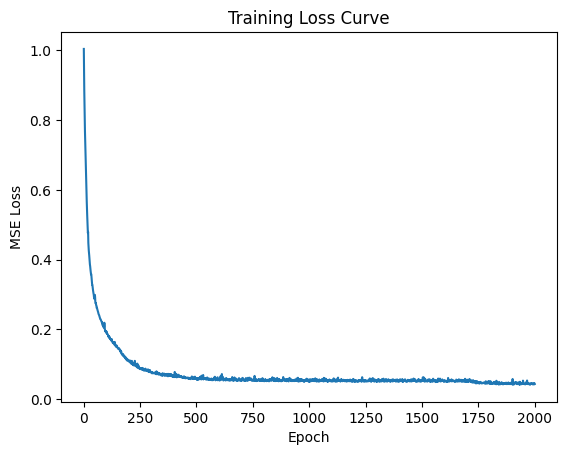

Fold 1 Validation MSE: 0.4302

=== Fold 2/10 ===
Epoch   1/2000  MSE=1.1372
Epoch  10/2000  MSE=0.8361
Epoch  20/2000  MSE=0.6735
Epoch  30/2000  MSE=0.5490
Epoch  40/2000  MSE=0.4531
Epoch  50/2000  MSE=0.3852
Epoch  60/2000  MSE=0.3518
Epoch  70/2000  MSE=0.3241
Epoch  80/2000  MSE=0.3019
Epoch  90/2000  MSE=0.2764
Epoch 100/2000  MSE=0.2516
Epoch 110/2000  MSE=0.2327
Epoch 120/2000  MSE=0.2197
Epoch 130/2000  MSE=0.2026
Epoch 140/2000  MSE=0.1913
Epoch 150/2000  MSE=0.1832
Epoch 160/2000  MSE=0.1733
Epoch 170/2000  MSE=0.1683
Epoch 180/2000  MSE=0.1623
Epoch 190/2000  MSE=0.1563
Epoch 200/2000  MSE=0.1516
Epoch 210/2000  MSE=0.1458
Epoch 220/2000  MSE=0.1430
Epoch 230/2000  MSE=0.1395
Epoch 240/2000  MSE=0.1369
Epoch 250/2000  MSE=0.1325
Epoch 260/2000  MSE=0.1312
Epoch 270/2000  MSE=0.1300
Epoch 280/2000  MSE=0.1275
Epoch 290/2000  MSE=0.1178
Epoch 300/2000  MSE=0.1032
Epoch 310/2000  MSE=0.0929
Epoch 320/2000  MSE=0.0852
Epoch 330/2000  MSE=0.0803
Epoch 340/2000  MSE=0.0778
Epoch 

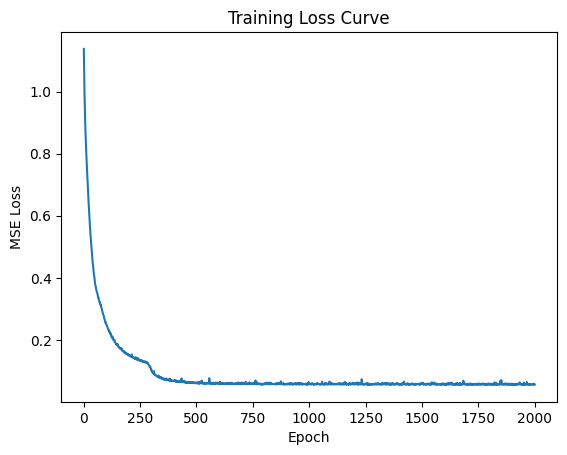

Fold 2 Validation MSE: 0.1470

=== Fold 3/10 ===
Epoch   1/2000  MSE=1.3748
Epoch  10/2000  MSE=1.1645
Epoch  20/2000  MSE=1.0671
Epoch  30/2000  MSE=1.0372
Epoch  40/2000  MSE=1.0292
Epoch  50/2000  MSE=1.0284
Epoch  60/2000  MSE=1.0275
Epoch  70/2000  MSE=1.0277
Epoch  80/2000  MSE=1.0273
Epoch  90/2000  MSE=1.0271
Epoch 100/2000  MSE=1.0277
Epoch 110/2000  MSE=1.0275
Epoch 120/2000  MSE=1.0279
Epoch 130/2000  MSE=1.0276
Epoch 140/2000  MSE=1.0275
Epoch 150/2000  MSE=1.0276
Epoch 160/2000  MSE=1.0275
Epoch 170/2000  MSE=1.0282
Epoch 180/2000  MSE=1.0277
Epoch 190/2000  MSE=1.0276
Epoch 200/2000  MSE=1.0276
Epoch 210/2000  MSE=1.0275
Epoch 220/2000  MSE=1.0274
Epoch 230/2000  MSE=1.0277
Epoch 240/2000  MSE=1.0280
Epoch 250/2000  MSE=1.0275
Epoch 260/2000  MSE=1.0280
Epoch 270/2000  MSE=1.0275
Epoch 280/2000  MSE=1.0276
Epoch 290/2000  MSE=1.0276
Epoch 300/2000  MSE=1.0276
Epoch 310/2000  MSE=1.0275
Epoch 320/2000  MSE=1.0276
Epoch 330/2000  MSE=1.0280
Epoch 340/2000  MSE=1.0283
Epoch 

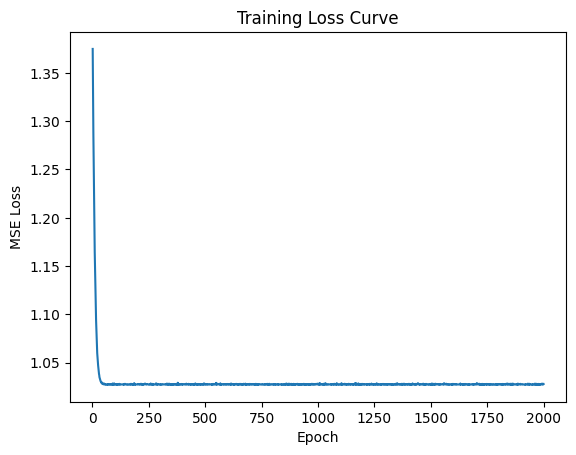

Fold 3 Validation MSE: 0.7664

=== Fold 4/10 ===
Epoch   1/2000  MSE=1.1153
Epoch  10/2000  MSE=0.9910
Epoch  20/2000  MSE=0.9555
Epoch  30/2000  MSE=0.9479
Epoch  40/2000  MSE=0.9468
Epoch  50/2000  MSE=0.9461
Epoch  60/2000  MSE=0.9464
Epoch  70/2000  MSE=0.9461
Epoch  80/2000  MSE=0.9468
Epoch  90/2000  MSE=0.9459
Epoch 100/2000  MSE=0.9461
Epoch 110/2000  MSE=0.9464
Epoch 120/2000  MSE=0.9466
Epoch 130/2000  MSE=0.9462
Epoch 140/2000  MSE=0.9463
Epoch 150/2000  MSE=0.9462
Epoch 160/2000  MSE=0.9461
Epoch 170/2000  MSE=0.9462
Epoch 180/2000  MSE=0.9461
Epoch 190/2000  MSE=0.9462
Epoch 200/2000  MSE=0.9465
Epoch 210/2000  MSE=0.9460
Epoch 220/2000  MSE=0.9461
Epoch 230/2000  MSE=0.9460
Epoch 240/2000  MSE=0.9462
Epoch 250/2000  MSE=0.9460
Epoch 260/2000  MSE=0.9461
Epoch 270/2000  MSE=0.9461
Epoch 280/2000  MSE=0.9463
Epoch 290/2000  MSE=0.9460
Epoch 300/2000  MSE=0.9460
Epoch 310/2000  MSE=0.9461
Epoch 320/2000  MSE=0.9460
Epoch 330/2000  MSE=0.9463
Epoch 340/2000  MSE=0.9466
Epoch 

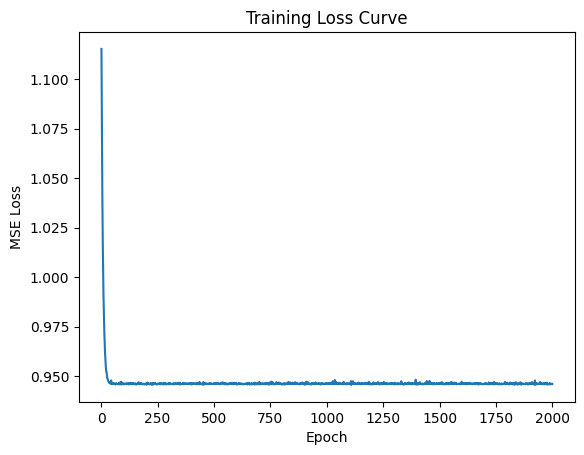

Fold 4 Validation MSE: 1.4713

=== Fold 5/10 ===
Epoch   1/2000  MSE=1.2990
Epoch  10/2000  MSE=1.0086
Epoch  20/2000  MSE=0.8167
Epoch  30/2000  MSE=0.6210
Epoch  40/2000  MSE=0.4697
Epoch  50/2000  MSE=0.3678
Epoch  60/2000  MSE=0.3159
Epoch  70/2000  MSE=0.2816
Epoch  80/2000  MSE=0.2464
Epoch  90/2000  MSE=0.2154
Epoch 100/2000  MSE=0.1833
Epoch 110/2000  MSE=0.1677
Epoch 120/2000  MSE=0.1399
Epoch 130/2000  MSE=0.1215
Epoch 140/2000  MSE=0.1054
Epoch 150/2000  MSE=0.1001
Epoch 160/2000  MSE=0.0833
Epoch 170/2000  MSE=0.0769
Epoch 180/2000  MSE=0.0736
Epoch 190/2000  MSE=0.0692
Epoch 200/2000  MSE=0.0648
Epoch 210/2000  MSE=0.0619
Epoch 220/2000  MSE=0.0630
Epoch 230/2000  MSE=0.0588
Epoch 240/2000  MSE=0.0595
Epoch 250/2000  MSE=0.0542
Epoch 260/2000  MSE=0.0598
Epoch 270/2000  MSE=0.0542
Epoch 280/2000  MSE=0.0524
Epoch 290/2000  MSE=0.0570
Epoch 300/2000  MSE=0.0529
Epoch 310/2000  MSE=0.0620
Epoch 320/2000  MSE=0.0516
Epoch 330/2000  MSE=0.0548
Epoch 340/2000  MSE=0.0491
Epoch 

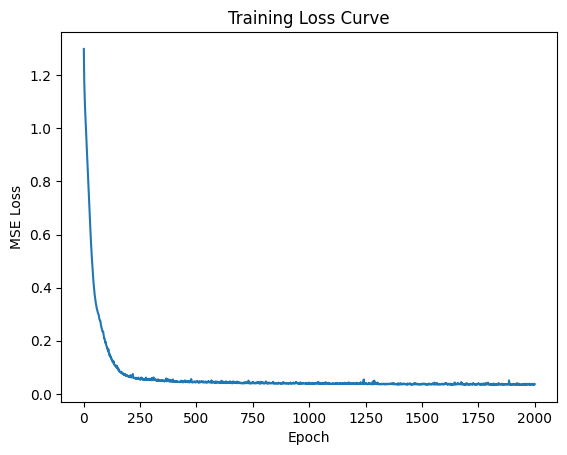

Fold 5 Validation MSE: 0.3573

=== Fold 6/10 ===
Epoch   1/2000  MSE=1.0282
Epoch  10/2000  MSE=0.9227
Epoch  20/2000  MSE=0.6715
Epoch  30/2000  MSE=0.5454
Epoch  40/2000  MSE=0.4603
Epoch  50/2000  MSE=0.4025
Epoch  60/2000  MSE=0.3554
Epoch  70/2000  MSE=0.3221
Epoch  80/2000  MSE=0.2962
Epoch  90/2000  MSE=0.2756
Epoch 100/2000  MSE=0.2544
Epoch 110/2000  MSE=0.2385
Epoch 120/2000  MSE=0.2156
Epoch 130/2000  MSE=0.1015
Epoch 140/2000  MSE=0.0749
Epoch 150/2000  MSE=0.0693
Epoch 160/2000  MSE=0.0680
Epoch 170/2000  MSE=0.0656
Epoch 180/2000  MSE=0.0652
Epoch 190/2000  MSE=0.0668
Epoch 200/2000  MSE=0.0638
Epoch 210/2000  MSE=0.0624
Epoch 220/2000  MSE=0.0633
Epoch 230/2000  MSE=0.0612
Epoch 240/2000  MSE=0.0618
Epoch 250/2000  MSE=0.0614
Epoch 260/2000  MSE=0.0612
Epoch 270/2000  MSE=0.0608
Epoch 280/2000  MSE=0.0613
Epoch 290/2000  MSE=0.0613
Epoch 300/2000  MSE=0.0631
Epoch 310/2000  MSE=0.0606
Epoch 320/2000  MSE=0.0618
Epoch 330/2000  MSE=0.0609
Epoch 340/2000  MSE=0.0593
Epoch 

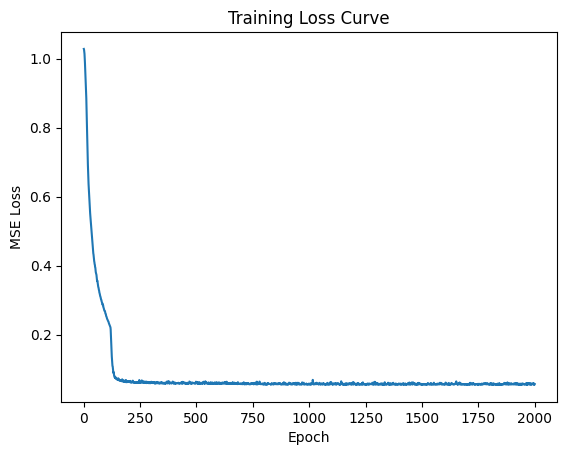

Fold 6 Validation MSE: 0.3104

=== Fold 7/10 ===
Epoch   1/2000  MSE=0.9561
Epoch  10/2000  MSE=0.5183
Epoch  20/2000  MSE=0.1446
Epoch  30/2000  MSE=0.1046
Epoch  40/2000  MSE=0.0892
Epoch  50/2000  MSE=0.0814
Epoch  60/2000  MSE=0.0764
Epoch  70/2000  MSE=0.0729
Epoch  80/2000  MSE=0.0701
Epoch  90/2000  MSE=0.0660
Epoch 100/2000  MSE=0.0669
Epoch 110/2000  MSE=0.0643
Epoch 120/2000  MSE=0.0619
Epoch 130/2000  MSE=0.0647
Epoch 140/2000  MSE=0.0614
Epoch 150/2000  MSE=0.0580
Epoch 160/2000  MSE=0.0593
Epoch 170/2000  MSE=0.0592
Epoch 180/2000  MSE=0.0593
Epoch 190/2000  MSE=0.0598
Epoch 200/2000  MSE=0.0571
Epoch 210/2000  MSE=0.0637
Epoch 220/2000  MSE=0.0571
Epoch 230/2000  MSE=0.0564
Epoch 240/2000  MSE=0.0602
Epoch 250/2000  MSE=0.0601
Epoch 260/2000  MSE=0.0555
Epoch 270/2000  MSE=0.0595
Epoch 280/2000  MSE=0.0551
Epoch 290/2000  MSE=0.0541
Epoch 300/2000  MSE=0.0550
Epoch 310/2000  MSE=0.0538
Epoch 320/2000  MSE=0.0523
Epoch 330/2000  MSE=0.0533
Epoch 340/2000  MSE=0.0530
Epoch 

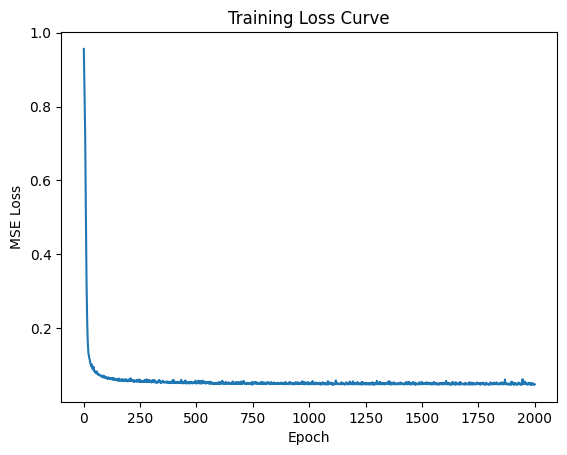

Fold 7 Validation MSE: 1.7955

=== Fold 8/10 ===
Epoch   1/2000  MSE=1.1394
Epoch  10/2000  MSE=0.5635
Epoch  20/2000  MSE=0.2623
Epoch  30/2000  MSE=0.2111
Epoch  40/2000  MSE=0.1937
Epoch  50/2000  MSE=0.1789
Epoch  60/2000  MSE=0.1704
Epoch  70/2000  MSE=0.1569
Epoch  80/2000  MSE=0.1538
Epoch  90/2000  MSE=0.1411
Epoch 100/2000  MSE=0.1348
Epoch 110/2000  MSE=0.1294
Epoch 120/2000  MSE=0.1248
Epoch 130/2000  MSE=0.1195
Epoch 140/2000  MSE=0.1179
Epoch 150/2000  MSE=0.1147
Epoch 160/2000  MSE=0.1107
Epoch 170/2000  MSE=0.1094
Epoch 180/2000  MSE=0.1084
Epoch 190/2000  MSE=0.1061
Epoch 200/2000  MSE=0.1187
Epoch 210/2000  MSE=0.1046
Epoch 220/2000  MSE=0.0948
Epoch 230/2000  MSE=0.0918
Epoch 240/2000  MSE=0.0905
Epoch 250/2000  MSE=0.0872
Epoch 260/2000  MSE=0.0867
Epoch 270/2000  MSE=0.0863
Epoch 280/2000  MSE=0.0832
Epoch 290/2000  MSE=0.0817
Epoch 300/2000  MSE=0.0811
Epoch 310/2000  MSE=0.0809
Epoch 320/2000  MSE=0.0798
Epoch 330/2000  MSE=0.0782
Epoch 340/2000  MSE=0.0826
Epoch 

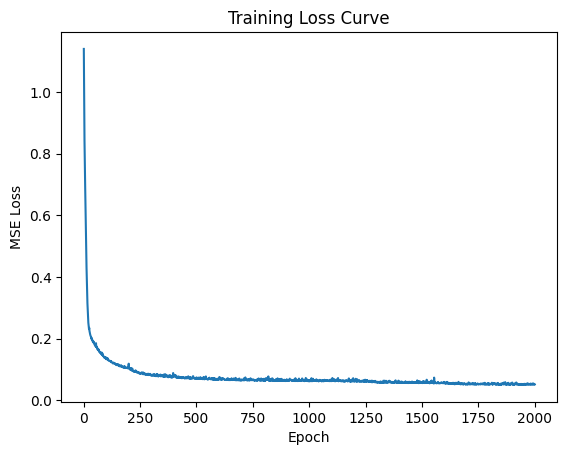

Fold 8 Validation MSE: 0.7698

=== Fold 9/10 ===
Epoch   1/2000  MSE=1.4962
Epoch  10/2000  MSE=0.8588
Epoch  20/2000  MSE=0.4434
Epoch  30/2000  MSE=0.2391
Epoch  40/2000  MSE=0.1877
Epoch  50/2000  MSE=0.1570
Epoch  60/2000  MSE=0.1444
Epoch  70/2000  MSE=0.1337
Epoch  80/2000  MSE=0.1228
Epoch  90/2000  MSE=0.1162
Epoch 100/2000  MSE=0.1114
Epoch 110/2000  MSE=0.1072
Epoch 120/2000  MSE=0.1060
Epoch 130/2000  MSE=0.1012
Epoch 140/2000  MSE=0.0978
Epoch 150/2000  MSE=0.0957
Epoch 160/2000  MSE=0.0934
Epoch 170/2000  MSE=0.0903
Epoch 180/2000  MSE=0.0887
Epoch 190/2000  MSE=0.0893
Epoch 200/2000  MSE=0.0741
Epoch 210/2000  MSE=0.0667
Epoch 220/2000  MSE=0.0618
Epoch 230/2000  MSE=0.0591
Epoch 240/2000  MSE=0.0586
Epoch 250/2000  MSE=0.0584
Epoch 260/2000  MSE=0.0548
Epoch 270/2000  MSE=0.0534
Epoch 280/2000  MSE=0.0521
Epoch 290/2000  MSE=0.0511
Epoch 300/2000  MSE=0.0494
Epoch 310/2000  MSE=0.0524
Epoch 320/2000  MSE=0.0490
Epoch 330/2000  MSE=0.0480
Epoch 340/2000  MSE=0.0479
Epoch 

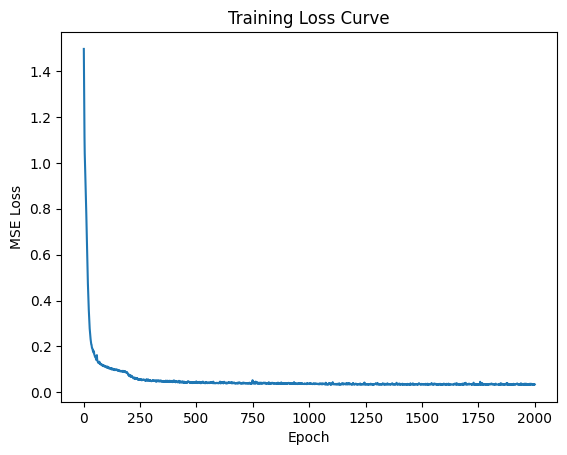

Fold 9 Validation MSE: 0.2171

=== Fold 10/10 ===
Epoch   1/2000  MSE=1.1251
Epoch  10/2000  MSE=0.8177
Epoch  20/2000  MSE=0.5892
Epoch  30/2000  MSE=0.4900
Epoch  40/2000  MSE=0.4118
Epoch  50/2000  MSE=0.3643
Epoch  60/2000  MSE=0.3191
Epoch  70/2000  MSE=0.2794
Epoch  80/2000  MSE=0.2474
Epoch  90/2000  MSE=0.2198
Epoch 100/2000  MSE=0.1999
Epoch 110/2000  MSE=0.1814
Epoch 120/2000  MSE=0.1682
Epoch 130/2000  MSE=0.1556
Epoch 140/2000  MSE=0.1430
Epoch 150/2000  MSE=0.1319
Epoch 160/2000  MSE=0.1248
Epoch 170/2000  MSE=0.1134
Epoch 180/2000  MSE=0.1062
Epoch 190/2000  MSE=0.1015
Epoch 200/2000  MSE=0.0969
Epoch 210/2000  MSE=0.0897
Epoch 220/2000  MSE=0.0905
Epoch 230/2000  MSE=0.0852
Epoch 240/2000  MSE=0.0823
Epoch 250/2000  MSE=0.0794
Epoch 260/2000  MSE=0.0771
Epoch 270/2000  MSE=0.0768
Epoch 280/2000  MSE=0.0735
Epoch 290/2000  MSE=0.0707
Epoch 300/2000  MSE=0.0752
Epoch 310/2000  MSE=0.0719
Epoch 320/2000  MSE=0.0696
Epoch 330/2000  MSE=0.0704
Epoch 340/2000  MSE=0.0723
Epoch

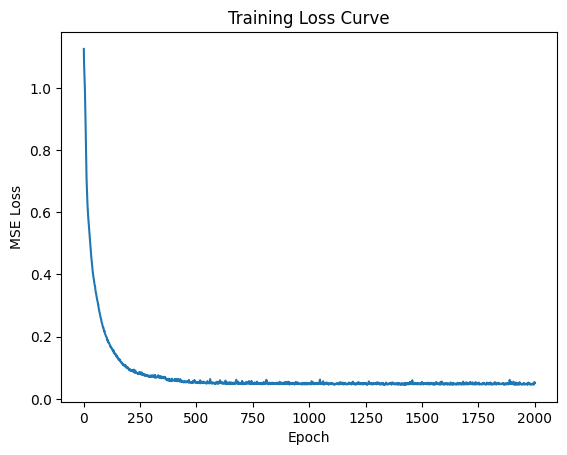

Fold 10 Validation MSE: 0.2860

=== CV Results: Mean MSE = 0.6551 ± 0.5326 ===
Fold 1 Validation MSE = 0.4302
Fold 2 Validation MSE = 0.1470
Fold 3 Validation MSE = 0.7664
Fold 4 Validation MSE = 1.4713
Fold 5 Validation MSE = 0.3573
Fold 6 Validation MSE = 0.3104
Fold 7 Validation MSE = 1.7955
Fold 8 Validation MSE = 0.7698
Fold 9 Validation MSE = 0.2171
Fold 10 Validation MSE = 0.2860
Saved fold 1 weights to: trained_model_bc97273c_fold1.pt
Saved fold 2 weights to: trained_model_bc97273c_fold2.pt
Saved fold 3 weights to: trained_model_bc97273c_fold3.pt
Saved fold 4 weights to: trained_model_bc97273c_fold4.pt
Saved fold 5 weights to: trained_model_bc97273c_fold5.pt
Saved fold 6 weights to: trained_model_bc97273c_fold6.pt
Saved fold 7 weights to: trained_model_bc97273c_fold7.pt
Saved fold 8 weights to: trained_model_bc97273c_fold8.pt
Saved fold 9 weights to: trained_model_bc97273c_fold9.pt
Saved fold 10 weights to: trained_model_bc97273c_fold10.pt
Saved training hyper-parameters to: tr

In [ ]:
import uuid
import torch

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [2, 2],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      2000,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 10
)

# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''


=== Fold 1/10 ===
Epoch   1/2000  MSE=1.1727
Epoch  10/2000  MSE=0.4874
Epoch  20/2000  MSE=0.2212
Epoch  30/2000  MSE=0.1326
Epoch  40/2000  MSE=0.0875
Epoch  50/2000  MSE=0.0687
Epoch  60/2000  MSE=0.0620
Epoch  70/2000  MSE=0.0574
Epoch  80/2000  MSE=0.0570
Epoch  90/2000  MSE=0.0478
Epoch 100/2000  MSE=0.0451
Epoch 110/2000  MSE=0.0436
Epoch 120/2000  MSE=0.0395
Epoch 130/2000  MSE=0.0389
Epoch 140/2000  MSE=0.0338
Epoch 150/2000  MSE=0.0343
Epoch 160/2000  MSE=0.0335
Epoch 170/2000  MSE=0.0299
Epoch 180/2000  MSE=0.0283
Epoch 190/2000  MSE=0.0269
Epoch 200/2000  MSE=0.0278
Epoch 210/2000  MSE=0.0255
Epoch 220/2000  MSE=0.0353
Epoch 230/2000  MSE=0.0270
Epoch 240/2000  MSE=0.0238
Epoch 250/2000  MSE=0.0247
Epoch 260/2000  MSE=0.0229
Epoch 270/2000  MSE=0.0228
Epoch 280/2000  MSE=0.0226
Epoch 290/2000  MSE=0.0246
Epoch 300/2000  MSE=0.0210
Epoch 310/2000  MSE=0.0207
Epoch 320/2000  MSE=0.0204
Epoch 330/2000  MSE=0.0214
Epoch 340/2000  MSE=0.0193
Epoch 350/2000  MSE=0.0238
Epoch 360

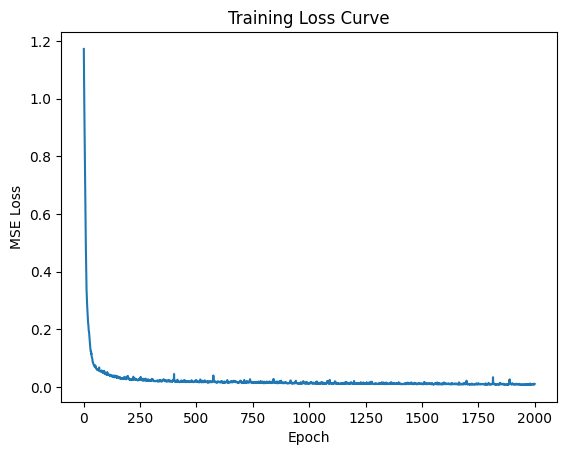

Fold 1 Validation MSE: 0.5165

=== Fold 2/10 ===
Epoch   1/2000  MSE=1.0479
Epoch  10/2000  MSE=0.5365
Epoch  20/2000  MSE=0.1697
Epoch  30/2000  MSE=0.1330
Epoch  40/2000  MSE=0.1097
Epoch  50/2000  MSE=0.0977
Epoch  60/2000  MSE=0.0852
Epoch  70/2000  MSE=0.0739
Epoch  80/2000  MSE=0.0658
Epoch  90/2000  MSE=0.0583
Epoch 100/2000  MSE=0.0535
Epoch 110/2000  MSE=0.0513
Epoch 120/2000  MSE=0.0475
Epoch 130/2000  MSE=0.0440
Epoch 140/2000  MSE=0.0432
Epoch 150/2000  MSE=0.0409
Epoch 160/2000  MSE=0.0419
Epoch 170/2000  MSE=0.0388
Epoch 180/2000  MSE=0.0393
Epoch 190/2000  MSE=0.0369
Epoch 200/2000  MSE=0.0342
Epoch 210/2000  MSE=0.0348
Epoch 220/2000  MSE=0.0315
Epoch 230/2000  MSE=0.0305
Epoch 240/2000  MSE=0.0287
Epoch 250/2000  MSE=0.0296
Epoch 260/2000  MSE=0.0272
Epoch 270/2000  MSE=0.0270
Epoch 280/2000  MSE=0.0263
Epoch 290/2000  MSE=0.0236
Epoch 300/2000  MSE=0.0230
Epoch 310/2000  MSE=0.0234
Epoch 320/2000  MSE=0.0258
Epoch 330/2000  MSE=0.0197
Epoch 340/2000  MSE=0.0193
Epoch 

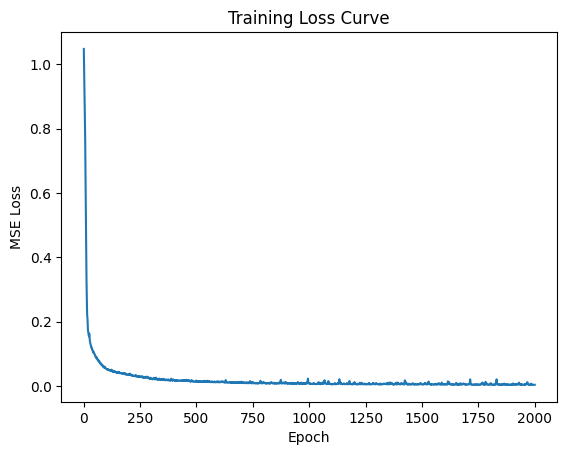

Fold 2 Validation MSE: 0.5348

=== Fold 3/10 ===
Epoch   1/2000  MSE=1.0993
Epoch  10/2000  MSE=0.4729
Epoch  20/2000  MSE=0.2340
Epoch  30/2000  MSE=0.1739
Epoch  40/2000  MSE=0.1291
Epoch  50/2000  MSE=0.0963
Epoch  60/2000  MSE=0.0804
Epoch  70/2000  MSE=0.0727
Epoch  80/2000  MSE=0.0585
Epoch  90/2000  MSE=0.0514
Epoch 100/2000  MSE=0.0468
Epoch 110/2000  MSE=0.0427
Epoch 120/2000  MSE=0.0413
Epoch 130/2000  MSE=0.0413
Epoch 140/2000  MSE=0.0374
Epoch 150/2000  MSE=0.0410
Epoch 160/2000  MSE=0.0352
Epoch 170/2000  MSE=0.0333
Epoch 180/2000  MSE=0.0321
Epoch 190/2000  MSE=0.0296
Epoch 200/2000  MSE=0.0295
Epoch 210/2000  MSE=0.0314
Epoch 220/2000  MSE=0.0281
Epoch 230/2000  MSE=0.0277
Epoch 240/2000  MSE=0.0261
Epoch 250/2000  MSE=0.0277
Epoch 260/2000  MSE=0.0273
Epoch 270/2000  MSE=0.0268
Epoch 280/2000  MSE=0.0251
Epoch 290/2000  MSE=0.0256
Epoch 300/2000  MSE=0.0267
Epoch 310/2000  MSE=0.0262
Epoch 320/2000  MSE=0.0251
Epoch 330/2000  MSE=0.0294
Epoch 340/2000  MSE=0.0242
Epoch 

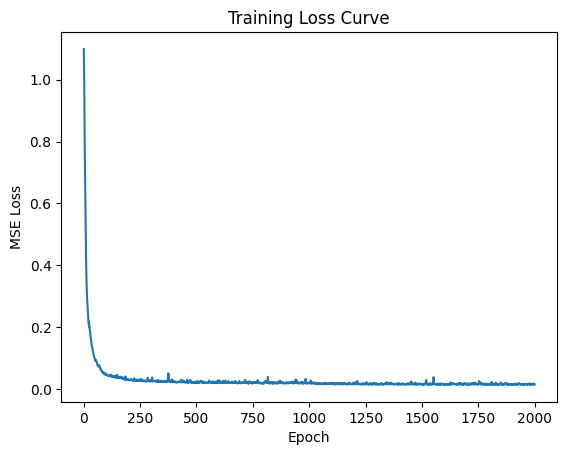

Fold 3 Validation MSE: 0.3189

=== Fold 4/10 ===
Epoch   1/2000  MSE=1.0157
Epoch  10/2000  MSE=0.5564
Epoch  20/2000  MSE=0.1938
Epoch  30/2000  MSE=0.1359
Epoch  40/2000  MSE=0.0941
Epoch  50/2000  MSE=0.0698
Epoch  60/2000  MSE=0.0576
Epoch  70/2000  MSE=0.0511
Epoch  80/2000  MSE=0.0454
Epoch  90/2000  MSE=0.0420
Epoch 100/2000  MSE=0.0386
Epoch 110/2000  MSE=0.0331
Epoch 120/2000  MSE=0.0317
Epoch 130/2000  MSE=0.0287
Epoch 140/2000  MSE=0.0283
Epoch 150/2000  MSE=0.0252
Epoch 160/2000  MSE=0.0245
Epoch 170/2000  MSE=0.0220
Epoch 180/2000  MSE=0.0225
Epoch 190/2000  MSE=0.0200
Epoch 200/2000  MSE=0.0190
Epoch 210/2000  MSE=0.0178
Epoch 220/2000  MSE=0.0173
Epoch 230/2000  MSE=0.0171
Epoch 240/2000  MSE=0.0163
Epoch 250/2000  MSE=0.0160
Epoch 260/2000  MSE=0.0170
Epoch 270/2000  MSE=0.0167
Epoch 280/2000  MSE=0.0150
Epoch 290/2000  MSE=0.0175
Epoch 300/2000  MSE=0.0155
Epoch 310/2000  MSE=0.0147
Epoch 320/2000  MSE=0.0168
Epoch 330/2000  MSE=0.0249
Epoch 340/2000  MSE=0.0154
Epoch 

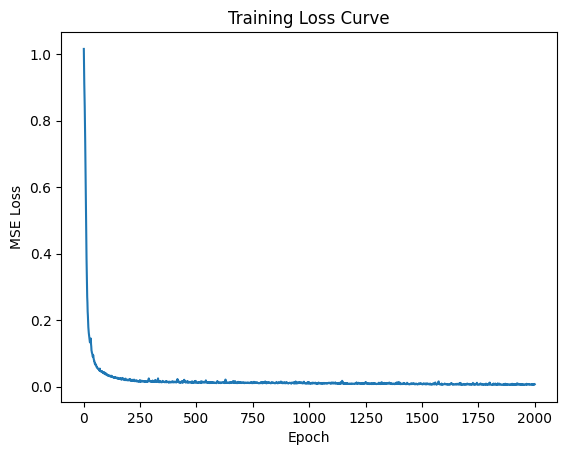

Fold 4 Validation MSE: 0.3008

=== Fold 5/10 ===
Epoch   1/2000  MSE=0.9211
Epoch  10/2000  MSE=0.6217
Epoch  20/2000  MSE=0.3412
Epoch  30/2000  MSE=0.1641
Epoch  40/2000  MSE=0.1223
Epoch  50/2000  MSE=0.0937
Epoch  60/2000  MSE=0.0790
Epoch  70/2000  MSE=0.0707
Epoch  80/2000  MSE=0.0544
Epoch  90/2000  MSE=0.0455
Epoch 100/2000  MSE=0.0438
Epoch 110/2000  MSE=0.0371
Epoch 120/2000  MSE=0.0339
Epoch 130/2000  MSE=0.0342
Epoch 140/2000  MSE=0.0345
Epoch 150/2000  MSE=0.0306
Epoch 160/2000  MSE=0.0280
Epoch 170/2000  MSE=0.0254
Epoch 180/2000  MSE=0.0293
Epoch 190/2000  MSE=0.0252
Epoch 200/2000  MSE=0.0245
Epoch 210/2000  MSE=0.0219
Epoch 220/2000  MSE=0.0239
Epoch 230/2000  MSE=0.0242
Epoch 240/2000  MSE=0.0209
Epoch 250/2000  MSE=0.0206
Epoch 260/2000  MSE=0.0196
Epoch 270/2000  MSE=0.0221
Epoch 280/2000  MSE=0.0220
Epoch 290/2000  MSE=0.0320
Epoch 300/2000  MSE=0.0210
Epoch 310/2000  MSE=0.0221
Epoch 320/2000  MSE=0.0199
Epoch 330/2000  MSE=0.0172
Epoch 340/2000  MSE=0.0182
Epoch 

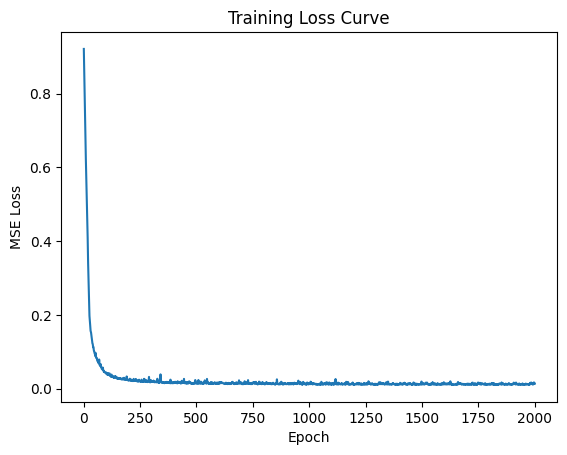

Fold 5 Validation MSE: 0.0893

=== Fold 6/10 ===
Epoch   1/2000  MSE=1.0659
Epoch  10/2000  MSE=0.4844
Epoch  20/2000  MSE=0.1535
Epoch  30/2000  MSE=0.1024
Epoch  40/2000  MSE=0.0760
Epoch  50/2000  MSE=0.0661
Epoch  60/2000  MSE=0.0595
Epoch  70/2000  MSE=0.0514
Epoch  80/2000  MSE=0.0451
Epoch  90/2000  MSE=0.0441
Epoch 100/2000  MSE=0.0428
Epoch 110/2000  MSE=0.0420
Epoch 120/2000  MSE=0.0391
Epoch 130/2000  MSE=0.0388
Epoch 140/2000  MSE=0.0382
Epoch 150/2000  MSE=0.0372
Epoch 160/2000  MSE=0.0394
Epoch 170/2000  MSE=0.0385
Epoch 180/2000  MSE=0.0367
Epoch 190/2000  MSE=0.0364
Epoch 200/2000  MSE=0.0379
Epoch 210/2000  MSE=0.0349
Epoch 220/2000  MSE=0.0374
Epoch 230/2000  MSE=0.0384
Epoch 240/2000  MSE=0.0332
Epoch 250/2000  MSE=0.0365
Epoch 260/2000  MSE=0.0329
Epoch 270/2000  MSE=0.0335
Epoch 280/2000  MSE=0.0309
Epoch 290/2000  MSE=0.0332
Epoch 300/2000  MSE=0.0355
Epoch 310/2000  MSE=0.0297
Epoch 320/2000  MSE=0.0310
Epoch 330/2000  MSE=0.0295
Epoch 340/2000  MSE=0.0320
Epoch 

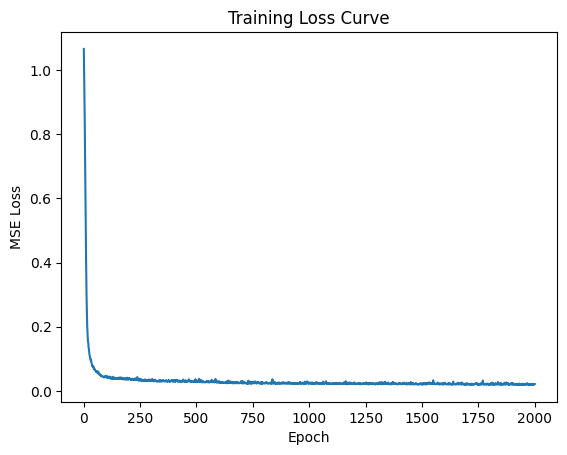

Fold 6 Validation MSE: 0.5401

=== Fold 7/10 ===
Epoch   1/2000  MSE=0.8888
Epoch  10/2000  MSE=0.4321
Epoch  20/2000  MSE=0.2040
Epoch  30/2000  MSE=0.1605
Epoch  40/2000  MSE=0.1380
Epoch  50/2000  MSE=0.1107
Epoch  60/2000  MSE=0.0949
Epoch  70/2000  MSE=0.0843
Epoch  80/2000  MSE=0.0761
Epoch  90/2000  MSE=0.0718
Epoch 100/2000  MSE=0.0606
Epoch 110/2000  MSE=0.0575
Epoch 120/2000  MSE=0.0515
Epoch 130/2000  MSE=0.0487
Epoch 140/2000  MSE=0.0443
Epoch 150/2000  MSE=0.0419
Epoch 160/2000  MSE=0.0409
Epoch 170/2000  MSE=0.0376
Epoch 180/2000  MSE=0.0370
Epoch 190/2000  MSE=0.0347
Epoch 200/2000  MSE=0.0363
Epoch 210/2000  MSE=0.0328
Epoch 220/2000  MSE=0.0318
Epoch 230/2000  MSE=0.0316
Epoch 240/2000  MSE=0.0305
Epoch 250/2000  MSE=0.0297
Epoch 260/2000  MSE=0.0317
Epoch 270/2000  MSE=0.0291
Epoch 280/2000  MSE=0.0288
Epoch 290/2000  MSE=0.0291
Epoch 300/2000  MSE=0.0291
Epoch 310/2000  MSE=0.0282
Epoch 320/2000  MSE=0.0305
Epoch 330/2000  MSE=0.0279
Epoch 340/2000  MSE=0.0269
Epoch 

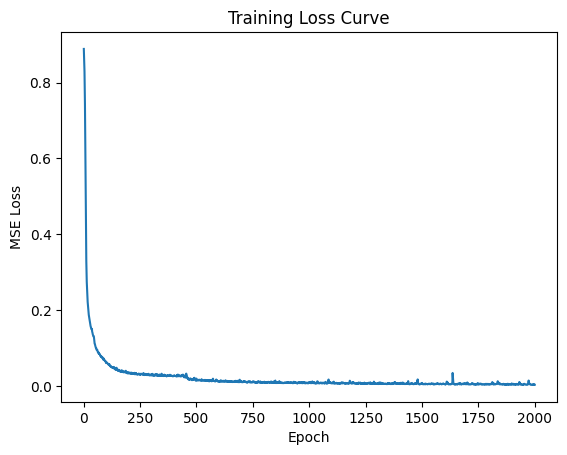

Fold 7 Validation MSE: 2.3067

=== Fold 8/10 ===
Epoch   1/2000  MSE=1.1623
Epoch  10/2000  MSE=0.7083
Epoch  20/2000  MSE=0.2403
Epoch  30/2000  MSE=0.1426
Epoch  40/2000  MSE=0.1043
Epoch  50/2000  MSE=0.0732
Epoch  60/2000  MSE=0.0584
Epoch  70/2000  MSE=0.0487
Epoch  80/2000  MSE=0.0383
Epoch  90/2000  MSE=0.0342
Epoch 100/2000  MSE=0.0363
Epoch 110/2000  MSE=0.0281
Epoch 120/2000  MSE=0.0277
Epoch 130/2000  MSE=0.0340
Epoch 140/2000  MSE=0.0280
Epoch 150/2000  MSE=0.0230
Epoch 160/2000  MSE=0.0216
Epoch 170/2000  MSE=0.0196
Epoch 180/2000  MSE=0.0204
Epoch 190/2000  MSE=0.0227
Epoch 200/2000  MSE=0.0211
Epoch 210/2000  MSE=0.0176
Epoch 220/2000  MSE=0.0207
Epoch 230/2000  MSE=0.0186
Epoch 240/2000  MSE=0.0169
Epoch 250/2000  MSE=0.0170
Epoch 260/2000  MSE=0.0237
Epoch 270/2000  MSE=0.0173
Epoch 280/2000  MSE=0.0174
Epoch 290/2000  MSE=0.0198
Epoch 300/2000  MSE=0.0261
Epoch 310/2000  MSE=0.0153
Epoch 320/2000  MSE=0.0155
Epoch 330/2000  MSE=0.0178
Epoch 340/2000  MSE=0.0136
Epoch 

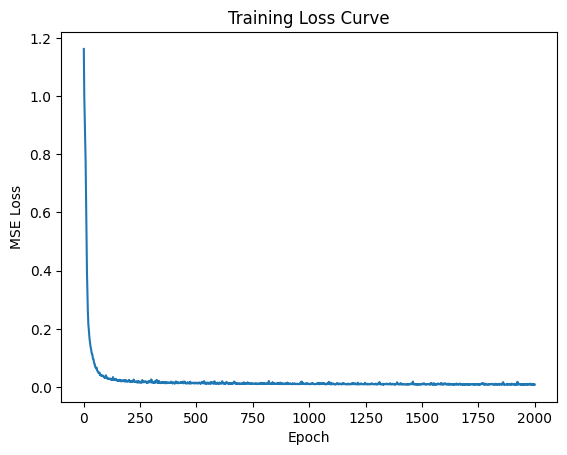

Fold 8 Validation MSE: 0.8043

=== Fold 9/10 ===
Epoch   1/2000  MSE=1.2555
Epoch  10/2000  MSE=1.1147
Epoch  20/2000  MSE=0.5954
Epoch  30/2000  MSE=0.3638
Epoch  40/2000  MSE=0.3023
Epoch  50/2000  MSE=0.2743
Epoch  60/2000  MSE=0.2599
Epoch  70/2000  MSE=0.2570
Epoch  80/2000  MSE=0.2487
Epoch  90/2000  MSE=0.2470
Epoch 100/2000  MSE=0.2429
Epoch 110/2000  MSE=0.2423
Epoch 120/2000  MSE=0.2406
Epoch 130/2000  MSE=0.2384
Epoch 140/2000  MSE=0.2396
Epoch 150/2000  MSE=0.2362
Epoch 160/2000  MSE=0.2354
Epoch 170/2000  MSE=0.2338
Epoch 180/2000  MSE=0.2339
Epoch 190/2000  MSE=0.2319
Epoch 200/2000  MSE=0.2308
Epoch 210/2000  MSE=0.2303
Epoch 220/2000  MSE=0.2226
Epoch 230/2000  MSE=0.2186
Epoch 240/2000  MSE=0.2176
Epoch 250/2000  MSE=0.2161
Epoch 260/2000  MSE=0.2157
Epoch 270/2000  MSE=0.2135
Epoch 280/2000  MSE=0.2142
Epoch 290/2000  MSE=0.2127
Epoch 300/2000  MSE=0.2132
Epoch 310/2000  MSE=0.2107
Epoch 320/2000  MSE=0.2094
Epoch 330/2000  MSE=0.2107
Epoch 340/2000  MSE=0.2088
Epoch 

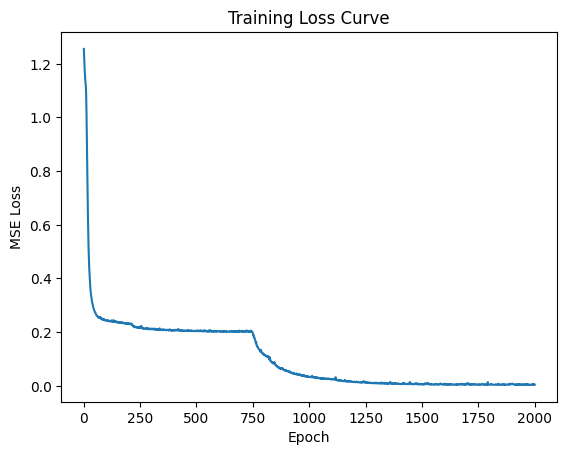

Fold 9 Validation MSE: 0.5816

=== Fold 10/10 ===
Epoch   1/2000  MSE=1.0398
Epoch  10/2000  MSE=0.6878
Epoch  20/2000  MSE=0.2735
Epoch  30/2000  MSE=0.1395
Epoch  40/2000  MSE=0.0915
Epoch  50/2000  MSE=0.0760
Epoch  60/2000  MSE=0.0680
Epoch  70/2000  MSE=0.0637
Epoch  80/2000  MSE=0.0556
Epoch  90/2000  MSE=0.0490
Epoch 100/2000  MSE=0.0460
Epoch 110/2000  MSE=0.0409
Epoch 120/2000  MSE=0.0372
Epoch 130/2000  MSE=0.0383
Epoch 140/2000  MSE=0.0337
Epoch 150/2000  MSE=0.0315
Epoch 160/2000  MSE=0.0295
Epoch 170/2000  MSE=0.0303
Epoch 180/2000  MSE=0.0268
Epoch 190/2000  MSE=0.0252
Epoch 200/2000  MSE=0.0237
Epoch 210/2000  MSE=0.0229
Epoch 220/2000  MSE=0.0220
Epoch 230/2000  MSE=0.0265
Epoch 240/2000  MSE=0.0206
Epoch 250/2000  MSE=0.0194
Epoch 260/2000  MSE=0.0199
Epoch 270/2000  MSE=0.0197
Epoch 280/2000  MSE=0.0292
Epoch 290/2000  MSE=0.0197
Epoch 300/2000  MSE=0.0195
Epoch 310/2000  MSE=0.0245
Epoch 320/2000  MSE=0.0181
Epoch 330/2000  MSE=0.0173
Epoch 340/2000  MSE=0.0169
Epoch

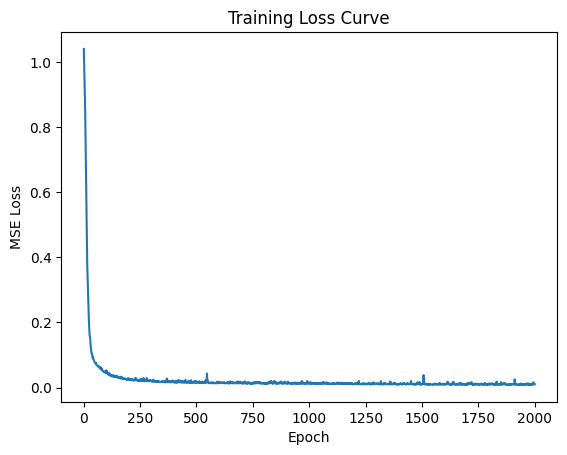

Fold 10 Validation MSE: 0.4731

=== CV Results: Mean MSE = 0.6466 ± 0.5825 ===
Fold 1 Validation MSE = 0.5165
Fold 2 Validation MSE = 0.5348
Fold 3 Validation MSE = 0.3189
Fold 4 Validation MSE = 0.3008
Fold 5 Validation MSE = 0.0893
Fold 6 Validation MSE = 0.5401
Fold 7 Validation MSE = 2.3067
Fold 8 Validation MSE = 0.8043
Fold 9 Validation MSE = 0.5816
Fold 10 Validation MSE = 0.4731


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [50]:
import uuid
import torch

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [4, 4],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      2000,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 10
)

# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''


=== Fold 1/10 ===
Epoch   1/2000  MSE=1.1647
Epoch  10/2000  MSE=0.5392
Epoch  20/2000  MSE=0.1735
Epoch  30/2000  MSE=0.1236
Epoch  40/2000  MSE=0.0988
Epoch  50/2000  MSE=0.0843
Epoch  60/2000  MSE=0.0777
Epoch  70/2000  MSE=0.0731
Epoch  80/2000  MSE=0.0691
Epoch  90/2000  MSE=0.0680
Epoch 100/2000  MSE=0.0643
Epoch 110/2000  MSE=0.0611
Epoch 120/2000  MSE=0.0595
Epoch 130/2000  MSE=0.0589
Epoch 140/2000  MSE=0.0554
Epoch 150/2000  MSE=0.0518
Epoch 160/2000  MSE=0.0504
Epoch 170/2000  MSE=0.0459
Epoch 180/2000  MSE=0.0459
Epoch 190/2000  MSE=0.0446
Epoch 200/2000  MSE=0.0410
Epoch 210/2000  MSE=0.0399
Epoch 220/2000  MSE=0.0392
Epoch 230/2000  MSE=0.0374
Epoch 240/2000  MSE=0.0351
Epoch 250/2000  MSE=0.0345
Epoch 260/2000  MSE=0.0331
Epoch 270/2000  MSE=0.0331
Epoch 280/2000  MSE=0.0353
Epoch 290/2000  MSE=0.0305
Epoch 300/2000  MSE=0.0296
Epoch 310/2000  MSE=0.0278
Epoch 320/2000  MSE=0.0283
Epoch 330/2000  MSE=0.0249
Epoch 340/2000  MSE=0.0254
Epoch 350/2000  MSE=0.0242
Epoch 360

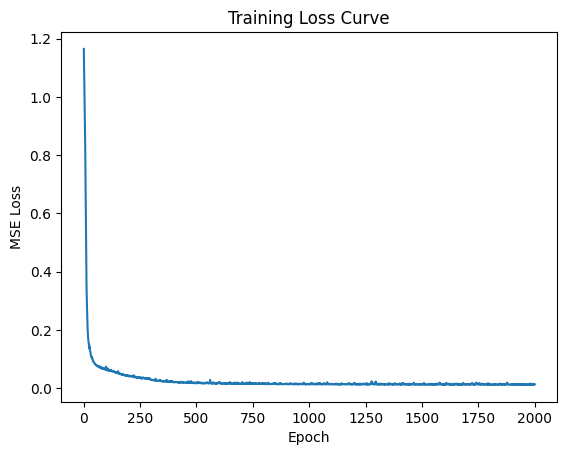

Fold 1 Validation MSE: 0.5267

=== Fold 2/10 ===
Epoch   1/2000  MSE=0.9919
Epoch  10/2000  MSE=0.6478
Epoch  20/2000  MSE=0.2648
Epoch  30/2000  MSE=0.1667
Epoch  40/2000  MSE=0.1261
Epoch  50/2000  MSE=0.0980
Epoch  60/2000  MSE=0.0833
Epoch  70/2000  MSE=0.0736
Epoch  80/2000  MSE=0.0707
Epoch  90/2000  MSE=0.0646
Epoch 100/2000  MSE=0.0563
Epoch 110/2000  MSE=0.0599
Epoch 120/2000  MSE=0.0548
Epoch 130/2000  MSE=0.0521
Epoch 140/2000  MSE=0.0515
Epoch 150/2000  MSE=0.0450
Epoch 160/2000  MSE=0.0425
Epoch 170/2000  MSE=0.0423
Epoch 180/2000  MSE=0.0417
Epoch 190/2000  MSE=0.0392
Epoch 200/2000  MSE=0.0423
Epoch 210/2000  MSE=0.0377
Epoch 220/2000  MSE=0.0367
Epoch 230/2000  MSE=0.0376
Epoch 240/2000  MSE=0.0348
Epoch 250/2000  MSE=0.0336
Epoch 260/2000  MSE=0.0362
Epoch 270/2000  MSE=0.0368
Epoch 280/2000  MSE=0.0354
Epoch 290/2000  MSE=0.0327
Epoch 300/2000  MSE=0.0408
Epoch 310/2000  MSE=0.0324
Epoch 320/2000  MSE=0.0339
Epoch 330/2000  MSE=0.0327
Epoch 340/2000  MSE=0.0338
Epoch 

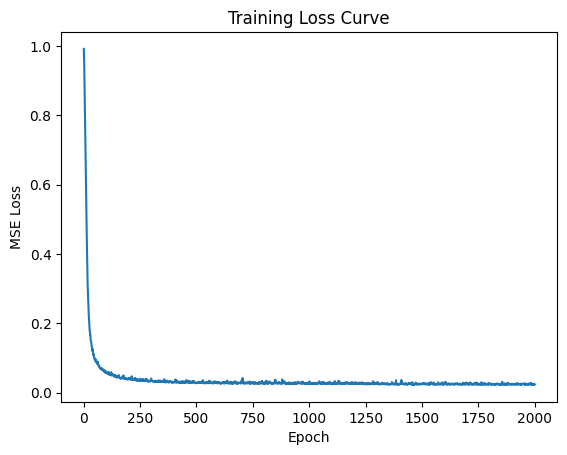

Fold 2 Validation MSE: 0.2940

=== Fold 3/10 ===
Epoch   1/2000  MSE=1.1136
Epoch  10/2000  MSE=0.6340
Epoch  20/2000  MSE=0.2119
Epoch  30/2000  MSE=0.1413
Epoch  40/2000  MSE=0.1197
Epoch  50/2000  MSE=0.1043
Epoch  60/2000  MSE=0.0920
Epoch  70/2000  MSE=0.0810
Epoch  80/2000  MSE=0.0762
Epoch  90/2000  MSE=0.0712
Epoch 100/2000  MSE=0.0683
Epoch 110/2000  MSE=0.0671
Epoch 120/2000  MSE=0.0620
Epoch 130/2000  MSE=0.0592
Epoch 140/2000  MSE=0.0574
Epoch 150/2000  MSE=0.0551
Epoch 160/2000  MSE=0.0568
Epoch 170/2000  MSE=0.0566
Epoch 180/2000  MSE=0.0536
Epoch 190/2000  MSE=0.0514
Epoch 200/2000  MSE=0.0501
Epoch 210/2000  MSE=0.0508
Epoch 220/2000  MSE=0.0487
Epoch 230/2000  MSE=0.0469
Epoch 240/2000  MSE=0.0482
Epoch 250/2000  MSE=0.0513
Epoch 260/2000  MSE=0.0459
Epoch 270/2000  MSE=0.0437
Epoch 280/2000  MSE=0.0472
Epoch 290/2000  MSE=0.0445
Epoch 300/2000  MSE=0.0463
Epoch 310/2000  MSE=0.0430
Epoch 320/2000  MSE=0.0432
Epoch 330/2000  MSE=0.0502
Epoch 340/2000  MSE=0.0423
Epoch 

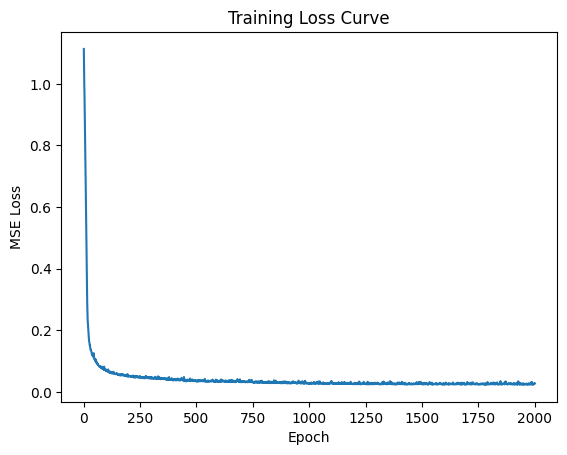

Fold 3 Validation MSE: 0.6962

=== Fold 4/10 ===
Epoch   1/2000  MSE=1.0126
Epoch  10/2000  MSE=0.8387
Epoch  20/2000  MSE=0.6689
Epoch  30/2000  MSE=0.4679
Epoch  40/2000  MSE=0.3420
Epoch  50/2000  MSE=0.2655
Epoch  60/2000  MSE=0.2186
Epoch  70/2000  MSE=0.1855
Epoch  80/2000  MSE=0.1672
Epoch  90/2000  MSE=0.1535
Epoch 100/2000  MSE=0.1427
Epoch 110/2000  MSE=0.1438
Epoch 120/2000  MSE=0.1301
Epoch 130/2000  MSE=0.1224
Epoch 140/2000  MSE=0.1180
Epoch 150/2000  MSE=0.1120
Epoch 160/2000  MSE=0.1103
Epoch 170/2000  MSE=0.1045
Epoch 180/2000  MSE=0.1017
Epoch 190/2000  MSE=0.0814
Epoch 200/2000  MSE=0.0801
Epoch 210/2000  MSE=0.0711
Epoch 220/2000  MSE=0.0679
Epoch 230/2000  MSE=0.0674
Epoch 240/2000  MSE=0.0658
Epoch 250/2000  MSE=0.0605
Epoch 260/2000  MSE=0.0581
Epoch 270/2000  MSE=0.0648
Epoch 280/2000  MSE=0.0548
Epoch 290/2000  MSE=0.0530
Epoch 300/2000  MSE=0.0515
Epoch 310/2000  MSE=0.0477
Epoch 320/2000  MSE=0.0474
Epoch 330/2000  MSE=0.0471
Epoch 340/2000  MSE=0.0518
Epoch 

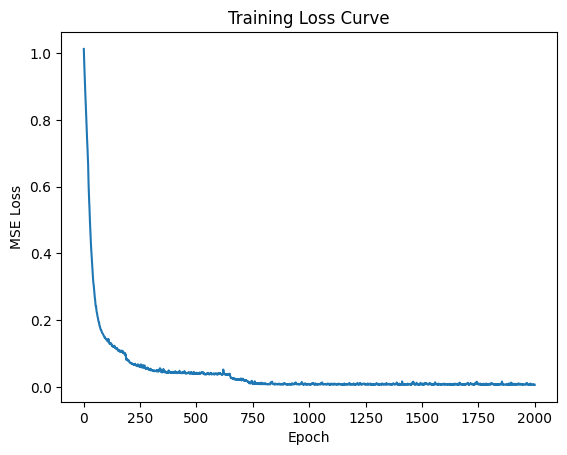

Fold 4 Validation MSE: 0.4850

=== Fold 5/10 ===
Epoch   1/2000  MSE=1.0732
Epoch  10/2000  MSE=0.5767
Epoch  20/2000  MSE=0.2967
Epoch  30/2000  MSE=0.2391
Epoch  40/2000  MSE=0.2093
Epoch  50/2000  MSE=0.1861
Epoch  60/2000  MSE=0.1745
Epoch  70/2000  MSE=0.1614
Epoch  80/2000  MSE=0.1533
Epoch  90/2000  MSE=0.1461
Epoch 100/2000  MSE=0.1255
Epoch 110/2000  MSE=0.1045
Epoch 120/2000  MSE=0.0898
Epoch 130/2000  MSE=0.0817
Epoch 140/2000  MSE=0.0782
Epoch 150/2000  MSE=0.0757
Epoch 160/2000  MSE=0.0659
Epoch 170/2000  MSE=0.0625
Epoch 180/2000  MSE=0.0573
Epoch 190/2000  MSE=0.0475
Epoch 200/2000  MSE=0.0474
Epoch 210/2000  MSE=0.0444
Epoch 220/2000  MSE=0.0406
Epoch 230/2000  MSE=0.0424
Epoch 240/2000  MSE=0.0381
Epoch 250/2000  MSE=0.0397
Epoch 260/2000  MSE=0.0354
Epoch 270/2000  MSE=0.0366
Epoch 280/2000  MSE=0.0356
Epoch 290/2000  MSE=0.0315
Epoch 300/2000  MSE=0.0326
Epoch 310/2000  MSE=0.0334
Epoch 320/2000  MSE=0.0291
Epoch 330/2000  MSE=0.0327
Epoch 340/2000  MSE=0.0320
Epoch 

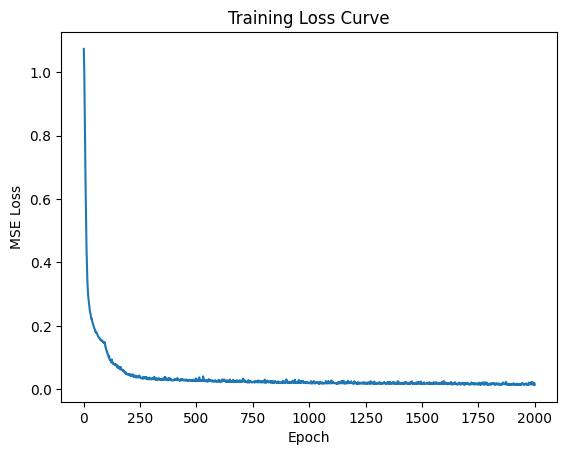

Fold 5 Validation MSE: 1.4747

=== Fold 6/10 ===
Epoch   1/2000  MSE=1.0756
Epoch  10/2000  MSE=0.6801
Epoch  20/2000  MSE=0.3343
Epoch  30/2000  MSE=0.2484
Epoch  40/2000  MSE=0.2196
Epoch  50/2000  MSE=0.1815
Epoch  60/2000  MSE=0.1603
Epoch  70/2000  MSE=0.1492
Epoch  80/2000  MSE=0.1398
Epoch  90/2000  MSE=0.1299
Epoch 100/2000  MSE=0.1236
Epoch 110/2000  MSE=0.1186
Epoch 120/2000  MSE=0.1170
Epoch 130/2000  MSE=0.1087
Epoch 140/2000  MSE=0.1023
Epoch 150/2000  MSE=0.1007
Epoch 160/2000  MSE=0.0964
Epoch 170/2000  MSE=0.0939
Epoch 180/2000  MSE=0.0900
Epoch 190/2000  MSE=0.0892
Epoch 200/2000  MSE=0.0849
Epoch 210/2000  MSE=0.0827
Epoch 220/2000  MSE=0.0823
Epoch 230/2000  MSE=0.0778
Epoch 240/2000  MSE=0.0828
Epoch 250/2000  MSE=0.0795
Epoch 260/2000  MSE=0.0754
Epoch 270/2000  MSE=0.0733
Epoch 280/2000  MSE=0.0717
Epoch 290/2000  MSE=0.0722
Epoch 300/2000  MSE=0.0749
Epoch 310/2000  MSE=0.0794
Epoch 320/2000  MSE=0.0631
Epoch 330/2000  MSE=0.0572
Epoch 340/2000  MSE=0.0548
Epoch 

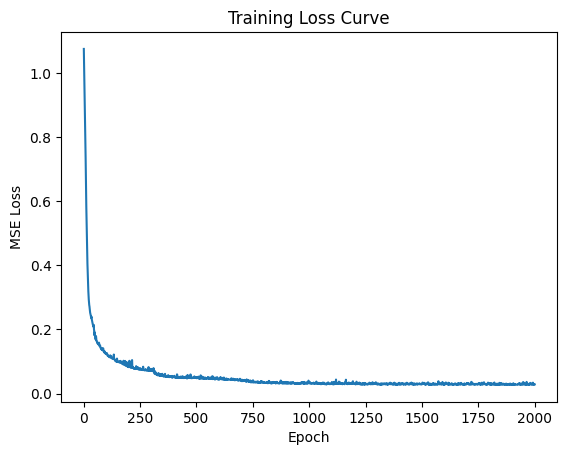

Fold 6 Validation MSE: 0.4042

=== Fold 7/10 ===
Epoch   1/2000  MSE=0.8680
Epoch  10/2000  MSE=0.4391
Epoch  20/2000  MSE=0.2193
Epoch  30/2000  MSE=0.1637
Epoch  40/2000  MSE=0.1421
Epoch  50/2000  MSE=0.1281
Epoch  60/2000  MSE=0.1173
Epoch  70/2000  MSE=0.1118
Epoch  80/2000  MSE=0.1002
Epoch  90/2000  MSE=0.0960
Epoch 100/2000  MSE=0.0909
Epoch 110/2000  MSE=0.0866
Epoch 120/2000  MSE=0.0808
Epoch 130/2000  MSE=0.0778
Epoch 140/2000  MSE=0.0720
Epoch 150/2000  MSE=0.0700
Epoch 160/2000  MSE=0.0698
Epoch 170/2000  MSE=0.0674
Epoch 180/2000  MSE=0.0669
Epoch 190/2000  MSE=0.0663
Epoch 200/2000  MSE=0.0624
Epoch 210/2000  MSE=0.0629
Epoch 220/2000  MSE=0.0526
Epoch 230/2000  MSE=0.0508
Epoch 240/2000  MSE=0.0511
Epoch 250/2000  MSE=0.0536
Epoch 260/2000  MSE=0.0521
Epoch 270/2000  MSE=0.0501
Epoch 280/2000  MSE=0.0478
Epoch 290/2000  MSE=0.0499
Epoch 300/2000  MSE=0.0471
Epoch 310/2000  MSE=0.0528
Epoch 320/2000  MSE=0.0474
Epoch 330/2000  MSE=0.0511
Epoch 340/2000  MSE=0.0452
Epoch 

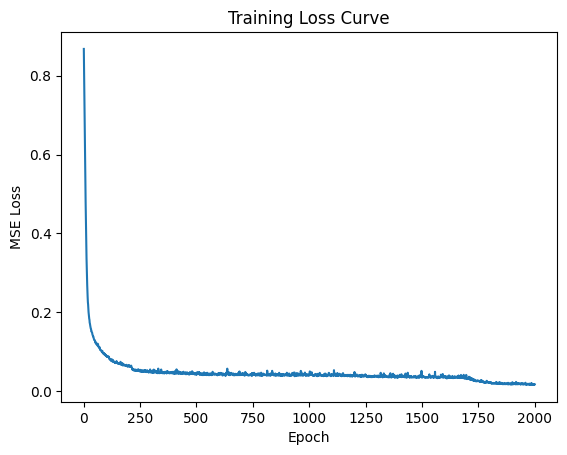

Fold 7 Validation MSE: 1.6844

=== Fold 8/10 ===
Epoch   1/2000  MSE=0.9725
Epoch  10/2000  MSE=0.6959
Epoch  20/2000  MSE=0.4663
Epoch  30/2000  MSE=0.3494
Epoch  40/2000  MSE=0.2233
Epoch  50/2000  MSE=0.1346
Epoch  60/2000  MSE=0.1003
Epoch  70/2000  MSE=0.0838
Epoch  80/2000  MSE=0.0747
Epoch  90/2000  MSE=0.0711
Epoch 100/2000  MSE=0.0685
Epoch 110/2000  MSE=0.0647
Epoch 120/2000  MSE=0.0615
Epoch 130/2000  MSE=0.0579
Epoch 140/2000  MSE=0.0516
Epoch 150/2000  MSE=0.0520
Epoch 160/2000  MSE=0.0481
Epoch 170/2000  MSE=0.0470
Epoch 180/2000  MSE=0.0483
Epoch 190/2000  MSE=0.0465
Epoch 200/2000  MSE=0.0462
Epoch 210/2000  MSE=0.0460
Epoch 220/2000  MSE=0.0444
Epoch 230/2000  MSE=0.0460
Epoch 240/2000  MSE=0.0441
Epoch 250/2000  MSE=0.0442
Epoch 260/2000  MSE=0.0449
Epoch 270/2000  MSE=0.0437
Epoch 280/2000  MSE=0.0449
Epoch 290/2000  MSE=0.0435
Epoch 300/2000  MSE=0.0430
Epoch 310/2000  MSE=0.0455
Epoch 320/2000  MSE=0.0418
Epoch 330/2000  MSE=0.0437
Epoch 340/2000  MSE=0.0419
Epoch 

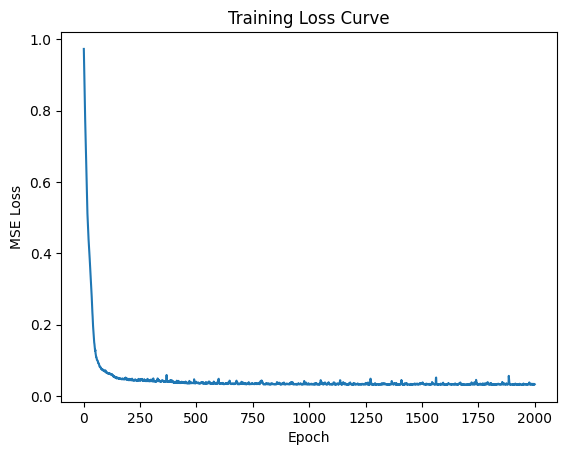

Fold 8 Validation MSE: 0.7798

=== Fold 9/10 ===
Epoch   1/2000  MSE=1.0786
Epoch  10/2000  MSE=0.6291
Epoch  20/2000  MSE=0.2846
Epoch  30/2000  MSE=0.2344
Epoch  40/2000  MSE=0.2082
Epoch  50/2000  MSE=0.1939
Epoch  60/2000  MSE=0.1776
Epoch  70/2000  MSE=0.1635
Epoch  80/2000  MSE=0.1521
Epoch  90/2000  MSE=0.1448
Epoch 100/2000  MSE=0.1364
Epoch 110/2000  MSE=0.1281
Epoch 120/2000  MSE=0.1312
Epoch 130/2000  MSE=0.1216
Epoch 140/2000  MSE=0.1142
Epoch 150/2000  MSE=0.1111
Epoch 160/2000  MSE=0.1026
Epoch 170/2000  MSE=0.0973
Epoch 180/2000  MSE=0.0937
Epoch 190/2000  MSE=0.0901
Epoch 200/2000  MSE=0.0852
Epoch 210/2000  MSE=0.0832
Epoch 220/2000  MSE=0.0809
Epoch 230/2000  MSE=0.0745
Epoch 240/2000  MSE=0.0790
Epoch 250/2000  MSE=0.0668
Epoch 260/2000  MSE=0.0567
Epoch 270/2000  MSE=0.0536
Epoch 280/2000  MSE=0.0490
Epoch 290/2000  MSE=0.0456
Epoch 300/2000  MSE=0.0456
Epoch 310/2000  MSE=0.0456
Epoch 320/2000  MSE=0.0387
Epoch 330/2000  MSE=0.0374
Epoch 340/2000  MSE=0.0372
Epoch 

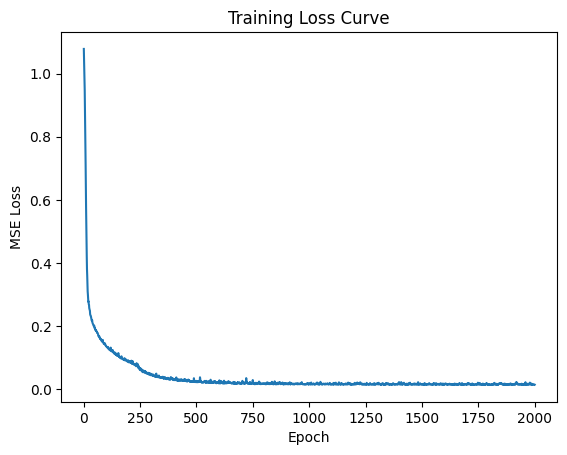

Fold 9 Validation MSE: 0.3555

=== Fold 10/10 ===
Epoch   1/2000  MSE=1.1001
Epoch  10/2000  MSE=0.4664
Epoch  20/2000  MSE=0.1685
Epoch  30/2000  MSE=0.1306
Epoch  40/2000  MSE=0.1077
Epoch  50/2000  MSE=0.0940
Epoch  60/2000  MSE=0.0848
Epoch  70/2000  MSE=0.0765
Epoch  80/2000  MSE=0.0704
Epoch  90/2000  MSE=0.0664
Epoch 100/2000  MSE=0.0628
Epoch 110/2000  MSE=0.0570
Epoch 120/2000  MSE=0.0524
Epoch 130/2000  MSE=0.0480
Epoch 140/2000  MSE=0.0476
Epoch 150/2000  MSE=0.0476
Epoch 160/2000  MSE=0.0436
Epoch 170/2000  MSE=0.0422
Epoch 180/2000  MSE=0.0416
Epoch 190/2000  MSE=0.0435
Epoch 200/2000  MSE=0.0420
Epoch 210/2000  MSE=0.0413
Epoch 220/2000  MSE=0.0408
Epoch 230/2000  MSE=0.0385
Epoch 240/2000  MSE=0.0427
Epoch 250/2000  MSE=0.0392
Epoch 260/2000  MSE=0.0387
Epoch 270/2000  MSE=0.0385
Epoch 280/2000  MSE=0.0382
Epoch 290/2000  MSE=0.0369
Epoch 300/2000  MSE=0.0369
Epoch 310/2000  MSE=0.0393
Epoch 320/2000  MSE=0.0441
Epoch 330/2000  MSE=0.0372
Epoch 340/2000  MSE=0.0360
Epoch

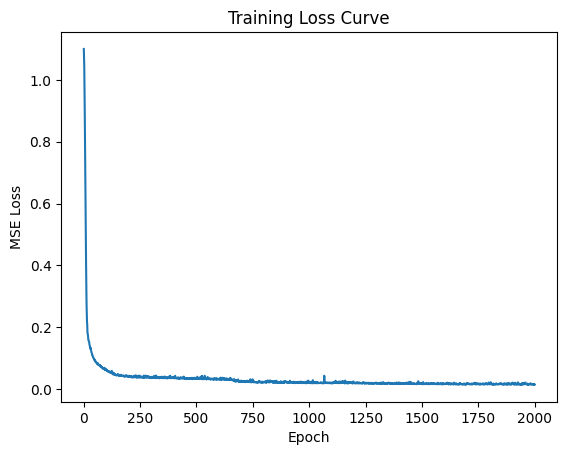

Fold 10 Validation MSE: 0.2439

=== CV Results: Mean MSE = 0.6944 ± 0.4723 ===
Fold 1 Validation MSE = 0.5267
Fold 2 Validation MSE = 0.2940
Fold 3 Validation MSE = 0.6962
Fold 4 Validation MSE = 0.4850
Fold 5 Validation MSE = 1.4747
Fold 6 Validation MSE = 0.4042
Fold 7 Validation MSE = 1.6844
Fold 8 Validation MSE = 0.7798
Fold 9 Validation MSE = 0.3555
Fold 10 Validation MSE = 0.2439


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [51]:
import uuid
import torch

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [3, 3],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      2000,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 10
)

# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''


=== Fold 1/10 ===
Epoch   1/1000  MSE=1.1661
Epoch  10/1000  MSE=0.5645
Epoch  20/1000  MSE=0.2197
Epoch  30/1000  MSE=0.1586
Epoch  40/1000  MSE=0.1315
Epoch  50/1000  MSE=0.1129
Epoch  60/1000  MSE=0.1084
Epoch  70/1000  MSE=0.1018
Epoch  80/1000  MSE=0.0929
Epoch  90/1000  MSE=0.0866
Epoch 100/1000  MSE=0.0784
Epoch 110/1000  MSE=0.0762
Epoch 120/1000  MSE=0.0685
Epoch 130/1000  MSE=0.0645
Epoch 140/1000  MSE=0.0624
Epoch 150/1000  MSE=0.0626
Epoch 160/1000  MSE=0.0575
Epoch 170/1000  MSE=0.0600
Epoch 180/1000  MSE=0.0548
Epoch 190/1000  MSE=0.0557
Epoch 200/1000  MSE=0.0488
Epoch 210/1000  MSE=0.0490
Epoch 220/1000  MSE=0.0510
Epoch 230/1000  MSE=0.0497
Epoch 240/1000  MSE=0.0474
Epoch 250/1000  MSE=0.0444
Epoch 260/1000  MSE=0.0444
Epoch 270/1000  MSE=0.0460
Epoch 280/1000  MSE=0.0448
Epoch 290/1000  MSE=0.0428
Epoch 300/1000  MSE=0.0394
Epoch 310/1000  MSE=0.0380
Epoch 320/1000  MSE=0.0392
Epoch 330/1000  MSE=0.0375
Epoch 340/1000  MSE=0.0390
Epoch 350/1000  MSE=0.0364
Epoch 360

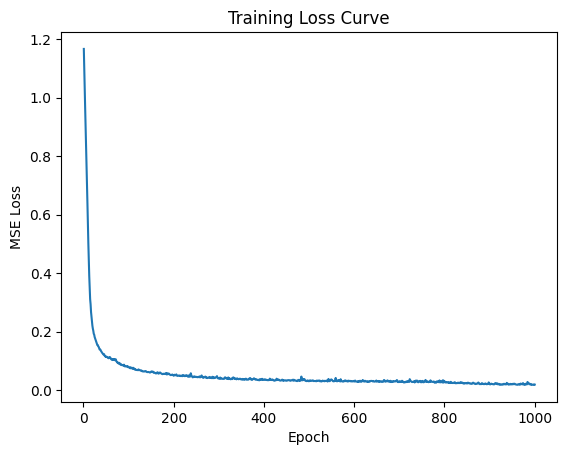

Fold 1 Validation MSE: 0.9150

=== Fold 2/10 ===
Epoch   1/1000  MSE=1.1802
Epoch  10/1000  MSE=0.4456
Epoch  20/1000  MSE=0.1951
Epoch  30/1000  MSE=0.1379
Epoch  40/1000  MSE=0.1103
Epoch  50/1000  MSE=0.0914
Epoch  60/1000  MSE=0.0860
Epoch  70/1000  MSE=0.0769
Epoch  80/1000  MSE=0.0784
Epoch  90/1000  MSE=0.0701
Epoch 100/1000  MSE=0.0673
Epoch 110/1000  MSE=0.0662
Epoch 120/1000  MSE=0.0610
Epoch 130/1000  MSE=0.0589
Epoch 140/1000  MSE=0.0566
Epoch 150/1000  MSE=0.0550
Epoch 160/1000  MSE=0.0541
Epoch 170/1000  MSE=0.0550
Epoch 180/1000  MSE=0.0606
Epoch 190/1000  MSE=0.0525
Epoch 200/1000  MSE=0.0477
Epoch 210/1000  MSE=0.0463
Epoch 220/1000  MSE=0.0453
Epoch 230/1000  MSE=0.0481
Epoch 240/1000  MSE=0.0437
Epoch 250/1000  MSE=0.0441
Epoch 260/1000  MSE=0.0425
Epoch 270/1000  MSE=0.0436
Epoch 280/1000  MSE=0.0475
Epoch 290/1000  MSE=0.0425
Epoch 300/1000  MSE=0.0419
Epoch 310/1000  MSE=0.0416
Epoch 320/1000  MSE=0.0429
Epoch 330/1000  MSE=0.0406
Epoch 340/1000  MSE=0.0411
Epoch 

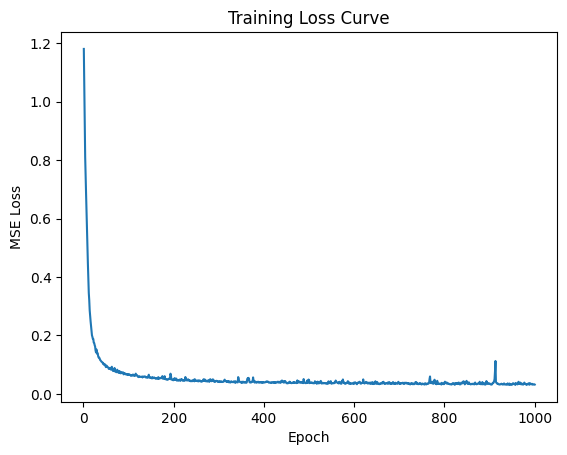

Fold 2 Validation MSE: 0.1166

=== Fold 3/10 ===
Epoch   1/1000  MSE=1.4308
Epoch  10/1000  MSE=0.9584
Epoch  20/1000  MSE=0.8111
Epoch  30/1000  MSE=0.6448
Epoch  40/1000  MSE=0.5216
Epoch  50/1000  MSE=0.4485
Epoch  60/1000  MSE=0.3912
Epoch  70/1000  MSE=0.3479
Epoch  80/1000  MSE=0.3115
Epoch  90/1000  MSE=0.2779
Epoch 100/1000  MSE=0.2479
Epoch 110/1000  MSE=0.2244
Epoch 120/1000  MSE=0.1985
Epoch 130/1000  MSE=0.1805
Epoch 140/1000  MSE=0.1643
Epoch 150/1000  MSE=0.1518
Epoch 160/1000  MSE=0.1408
Epoch 170/1000  MSE=0.1353
Epoch 180/1000  MSE=0.1282
Epoch 190/1000  MSE=0.1224
Epoch 200/1000  MSE=0.1174
Epoch 210/1000  MSE=0.1142
Epoch 220/1000  MSE=0.1129
Epoch 230/1000  MSE=0.1068
Epoch 240/1000  MSE=0.1057
Epoch 250/1000  MSE=0.0990
Epoch 260/1000  MSE=0.0993
Epoch 270/1000  MSE=0.0937
Epoch 280/1000  MSE=0.0863
Epoch 290/1000  MSE=0.0800
Epoch 300/1000  MSE=0.0796
Epoch 310/1000  MSE=0.0742
Epoch 320/1000  MSE=0.0684
Epoch 330/1000  MSE=0.0659
Epoch 340/1000  MSE=0.0623
Epoch 

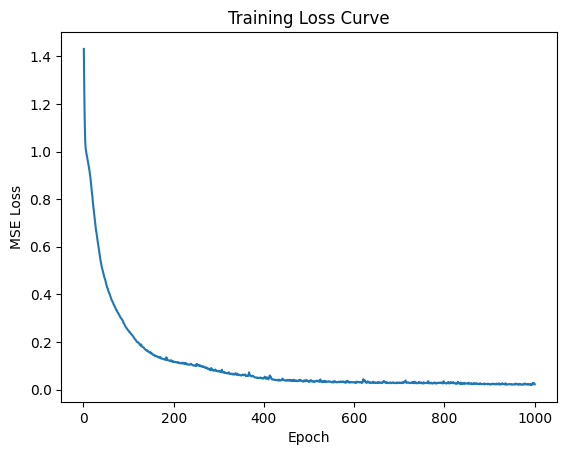

Fold 3 Validation MSE: 0.0935

=== Fold 4/10 ===
Epoch   1/1000  MSE=1.0630
Epoch  10/1000  MSE=0.7497
Epoch  20/1000  MSE=0.2586
Epoch  30/1000  MSE=0.1718
Epoch  40/1000  MSE=0.1233
Epoch  50/1000  MSE=0.0958
Epoch  60/1000  MSE=0.0826
Epoch  70/1000  MSE=0.0744
Epoch  80/1000  MSE=0.0714
Epoch  90/1000  MSE=0.0640
Epoch 100/1000  MSE=0.0601
Epoch 110/1000  MSE=0.0570
Epoch 120/1000  MSE=0.0578
Epoch 130/1000  MSE=0.0547
Epoch 140/1000  MSE=0.0526
Epoch 150/1000  MSE=0.0511
Epoch 160/1000  MSE=0.0482
Epoch 170/1000  MSE=0.0501
Epoch 180/1000  MSE=0.0464
Epoch 190/1000  MSE=0.0442
Epoch 200/1000  MSE=0.0452
Epoch 210/1000  MSE=0.0452
Epoch 220/1000  MSE=0.0439
Epoch 230/1000  MSE=0.0438
Epoch 240/1000  MSE=0.0451
Epoch 250/1000  MSE=0.0424
Epoch 260/1000  MSE=0.0425
Epoch 270/1000  MSE=0.0418
Epoch 280/1000  MSE=0.0411
Epoch 290/1000  MSE=0.0423
Epoch 300/1000  MSE=0.0431
Epoch 310/1000  MSE=0.0401
Epoch 320/1000  MSE=0.0418
Epoch 330/1000  MSE=0.0407
Epoch 340/1000  MSE=0.0404
Epoch 

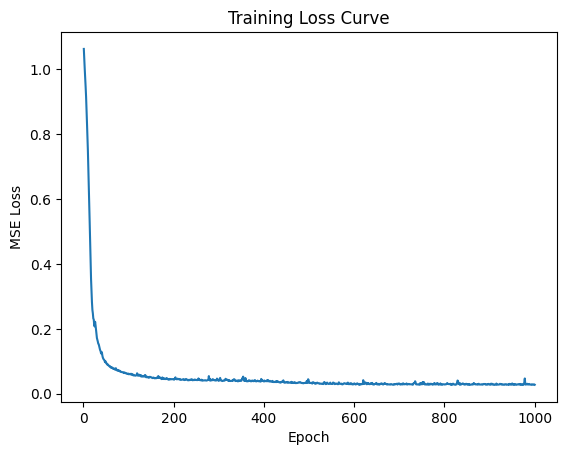

Fold 4 Validation MSE: 0.5077

=== Fold 5/10 ===
Epoch   1/1000  MSE=0.9594
Epoch  10/1000  MSE=0.6640
Epoch  20/1000  MSE=0.5041
Epoch  30/1000  MSE=0.3914
Epoch  40/1000  MSE=0.3220
Epoch  50/1000  MSE=0.2791
Epoch  60/1000  MSE=0.2461
Epoch  70/1000  MSE=0.2181
Epoch  80/1000  MSE=0.2010
Epoch  90/1000  MSE=0.1717
Epoch 100/1000  MSE=0.1497
Epoch 110/1000  MSE=0.1369
Epoch 120/1000  MSE=0.1212
Epoch 130/1000  MSE=0.0736
Epoch 140/1000  MSE=0.0664
Epoch 150/1000  MSE=0.0622
Epoch 160/1000  MSE=0.0603
Epoch 170/1000  MSE=0.0480
Epoch 180/1000  MSE=0.0389
Epoch 190/1000  MSE=0.0379
Epoch 200/1000  MSE=0.0369
Epoch 210/1000  MSE=0.0320
Epoch 220/1000  MSE=0.0317
Epoch 230/1000  MSE=0.0326
Epoch 240/1000  MSE=0.0286
Epoch 250/1000  MSE=0.0278
Epoch 260/1000  MSE=0.0263
Epoch 270/1000  MSE=0.0268
Epoch 280/1000  MSE=0.0256
Epoch 290/1000  MSE=0.0246
Epoch 300/1000  MSE=0.0253
Epoch 310/1000  MSE=0.0271
Epoch 320/1000  MSE=0.0231
Epoch 330/1000  MSE=0.0230
Epoch 340/1000  MSE=0.0230
Epoch 

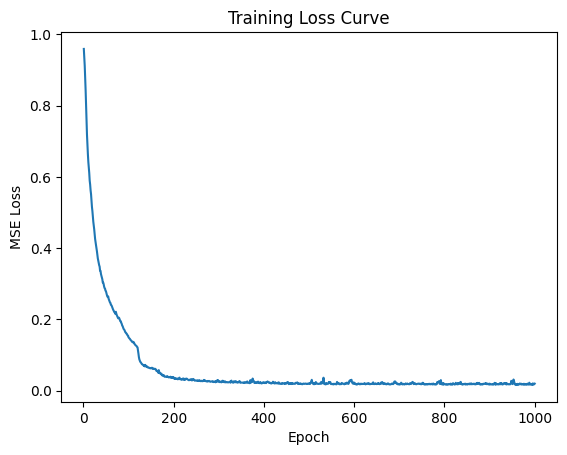

Fold 5 Validation MSE: 0.2026

=== Fold 6/10 ===
Epoch   1/1000  MSE=1.2121
Epoch  10/1000  MSE=0.8759
Epoch  20/1000  MSE=0.5079
Epoch  30/1000  MSE=0.3259
Epoch  40/1000  MSE=0.2315
Epoch  50/1000  MSE=0.1710
Epoch  60/1000  MSE=0.1203
Epoch  70/1000  MSE=0.0922
Epoch  80/1000  MSE=0.0740
Epoch  90/1000  MSE=0.0618
Epoch 100/1000  MSE=0.0532
Epoch 110/1000  MSE=0.0477
Epoch 120/1000  MSE=0.0469
Epoch 130/1000  MSE=0.0426
Epoch 140/1000  MSE=0.0416
Epoch 150/1000  MSE=0.0397
Epoch 160/1000  MSE=0.0396
Epoch 170/1000  MSE=0.0394
Epoch 180/1000  MSE=0.0377
Epoch 190/1000  MSE=0.0372
Epoch 200/1000  MSE=0.0350
Epoch 210/1000  MSE=0.0330
Epoch 220/1000  MSE=0.0330
Epoch 230/1000  MSE=0.0304
Epoch 240/1000  MSE=0.0293
Epoch 250/1000  MSE=0.0308
Epoch 260/1000  MSE=0.0305
Epoch 270/1000  MSE=0.0271
Epoch 280/1000  MSE=0.0300
Epoch 290/1000  MSE=0.0268
Epoch 300/1000  MSE=0.0261
Epoch 310/1000  MSE=0.0323
Epoch 320/1000  MSE=0.0247
Epoch 330/1000  MSE=0.0249
Epoch 340/1000  MSE=0.0237
Epoch 

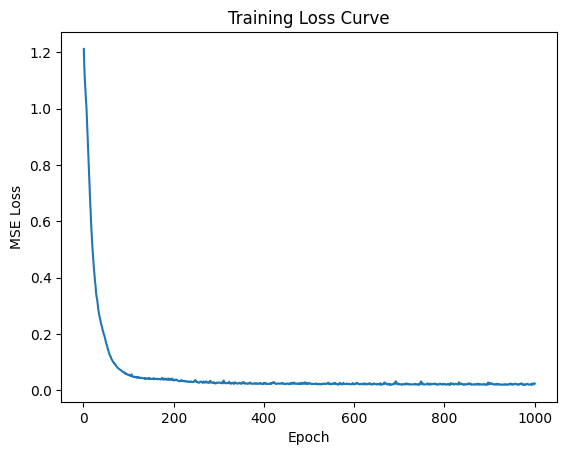

Fold 6 Validation MSE: 0.7284

=== Fold 7/10 ===
Epoch   1/1000  MSE=0.9185
Epoch  10/1000  MSE=0.3866
Epoch  20/1000  MSE=0.1617
Epoch  30/1000  MSE=0.1166
Epoch  40/1000  MSE=0.1032
Epoch  50/1000  MSE=0.0916
Epoch  60/1000  MSE=0.0849
Epoch  70/1000  MSE=0.0797
Epoch  80/1000  MSE=0.0755
Epoch  90/1000  MSE=0.0746
Epoch 100/1000  MSE=0.0696
Epoch 110/1000  MSE=0.0699
Epoch 120/1000  MSE=0.0637
Epoch 130/1000  MSE=0.0595
Epoch 140/1000  MSE=0.0572
Epoch 150/1000  MSE=0.0551
Epoch 160/1000  MSE=0.0556
Epoch 170/1000  MSE=0.0543
Epoch 180/1000  MSE=0.0510
Epoch 190/1000  MSE=0.0495
Epoch 200/1000  MSE=0.0503
Epoch 210/1000  MSE=0.0515
Epoch 220/1000  MSE=0.0492
Epoch 230/1000  MSE=0.0491
Epoch 240/1000  MSE=0.0485
Epoch 250/1000  MSE=0.0486
Epoch 260/1000  MSE=0.0474
Epoch 270/1000  MSE=0.0471
Epoch 280/1000  MSE=0.0483
Epoch 290/1000  MSE=0.0484
Epoch 300/1000  MSE=0.0476
Epoch 310/1000  MSE=0.0477
Epoch 320/1000  MSE=0.0436
Epoch 330/1000  MSE=0.0445
Epoch 340/1000  MSE=0.0437
Epoch 

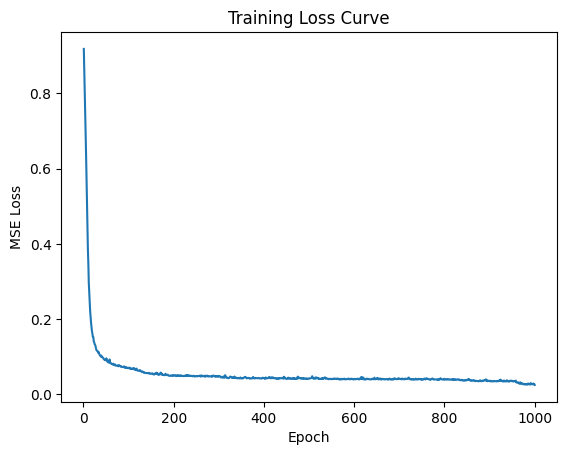

Fold 7 Validation MSE: 2.0886

=== Fold 8/10 ===
Epoch   1/1000  MSE=1.0454
Epoch  10/1000  MSE=0.5774
Epoch  20/1000  MSE=0.2606
Epoch  30/1000  MSE=0.2093
Epoch  40/1000  MSE=0.1869
Epoch  50/1000  MSE=0.1709
Epoch  60/1000  MSE=0.1605
Epoch  70/1000  MSE=0.1442
Epoch  80/1000  MSE=0.1335
Epoch  90/1000  MSE=0.1241
Epoch 100/1000  MSE=0.1192
Epoch 110/1000  MSE=0.0984
Epoch 120/1000  MSE=0.0799
Epoch 130/1000  MSE=0.0728
Epoch 140/1000  MSE=0.0634
Epoch 150/1000  MSE=0.0603
Epoch 160/1000  MSE=0.0563
Epoch 170/1000  MSE=0.0547
Epoch 180/1000  MSE=0.0515
Epoch 190/1000  MSE=0.0548
Epoch 200/1000  MSE=0.0454
Epoch 210/1000  MSE=0.0436
Epoch 220/1000  MSE=0.0448
Epoch 230/1000  MSE=0.0410
Epoch 240/1000  MSE=0.0438
Epoch 250/1000  MSE=0.0390
Epoch 260/1000  MSE=0.0406
Epoch 270/1000  MSE=0.0366
Epoch 280/1000  MSE=0.0348
Epoch 290/1000  MSE=0.0351
Epoch 300/1000  MSE=0.0343
Epoch 310/1000  MSE=0.0386
Epoch 320/1000  MSE=0.0359
Epoch 330/1000  MSE=0.0347
Epoch 340/1000  MSE=0.0349
Epoch 

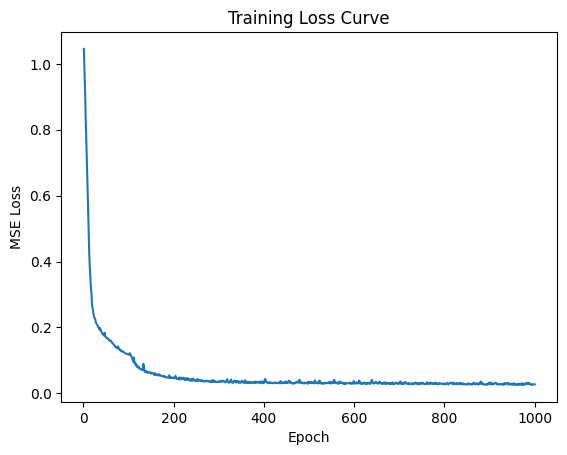

Fold 8 Validation MSE: 0.4999

=== Fold 9/10 ===
Epoch   1/1000  MSE=1.0749
Epoch  10/1000  MSE=0.8650
Epoch  20/1000  MSE=0.2847
Epoch  30/1000  MSE=0.1610
Epoch  40/1000  MSE=0.1353
Epoch  50/1000  MSE=0.1150
Epoch  60/1000  MSE=0.1044
Epoch  70/1000  MSE=0.0960
Epoch  80/1000  MSE=0.0878
Epoch  90/1000  MSE=0.0772
Epoch 100/1000  MSE=0.0706
Epoch 110/1000  MSE=0.0662
Epoch 120/1000  MSE=0.0608
Epoch 130/1000  MSE=0.0566
Epoch 140/1000  MSE=0.0560
Epoch 150/1000  MSE=0.0500
Epoch 160/1000  MSE=0.0476
Epoch 170/1000  MSE=0.0474
Epoch 180/1000  MSE=0.0411
Epoch 190/1000  MSE=0.0381
Epoch 200/1000  MSE=0.0366
Epoch 210/1000  MSE=0.0345
Epoch 220/1000  MSE=0.0398
Epoch 230/1000  MSE=0.0321
Epoch 240/1000  MSE=0.0326
Epoch 250/1000  MSE=0.0302
Epoch 260/1000  MSE=0.0297
Epoch 270/1000  MSE=0.0305
Epoch 280/1000  MSE=0.0279
Epoch 290/1000  MSE=0.0280
Epoch 300/1000  MSE=0.0319
Epoch 310/1000  MSE=0.0294
Epoch 320/1000  MSE=0.0276
Epoch 330/1000  MSE=0.0277
Epoch 340/1000  MSE=0.0265
Epoch 

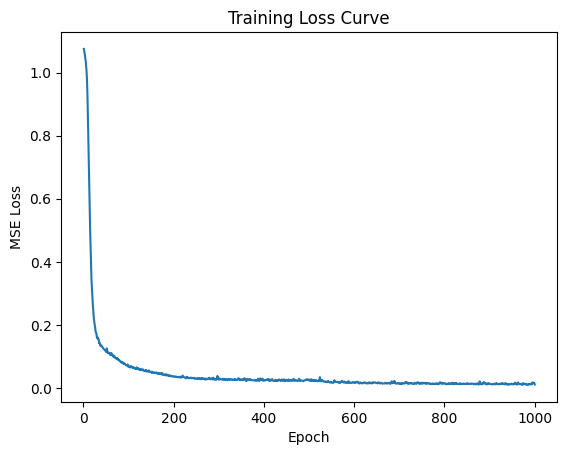

Fold 9 Validation MSE: 0.1895

=== Fold 10/10 ===
Epoch   1/1000  MSE=1.1263
Epoch  10/1000  MSE=0.8435
Epoch  20/1000  MSE=0.6014
Epoch  30/1000  MSE=0.4907
Epoch  40/1000  MSE=0.3528
Epoch  50/1000  MSE=0.1408
Epoch  60/1000  MSE=0.1075
Epoch  70/1000  MSE=0.0989
Epoch  80/1000  MSE=0.0918
Epoch  90/1000  MSE=0.0857
Epoch 100/1000  MSE=0.0830
Epoch 110/1000  MSE=0.0804
Epoch 120/1000  MSE=0.0805
Epoch 130/1000  MSE=0.0765
Epoch 140/1000  MSE=0.0733
Epoch 150/1000  MSE=0.0703
Epoch 160/1000  MSE=0.0697
Epoch 170/1000  MSE=0.0685
Epoch 180/1000  MSE=0.0670
Epoch 190/1000  MSE=0.0656
Epoch 200/1000  MSE=0.0647
Epoch 210/1000  MSE=0.0628
Epoch 220/1000  MSE=0.0631
Epoch 230/1000  MSE=0.0626
Epoch 240/1000  MSE=0.0621
Epoch 250/1000  MSE=0.0609
Epoch 260/1000  MSE=0.0609
Epoch 270/1000  MSE=0.0582
Epoch 280/1000  MSE=0.0583
Epoch 290/1000  MSE=0.0579
Epoch 300/1000  MSE=0.0587
Epoch 310/1000  MSE=0.0568
Epoch 320/1000  MSE=0.0574
Epoch 330/1000  MSE=0.0581
Epoch 340/1000  MSE=0.0553
Epoch

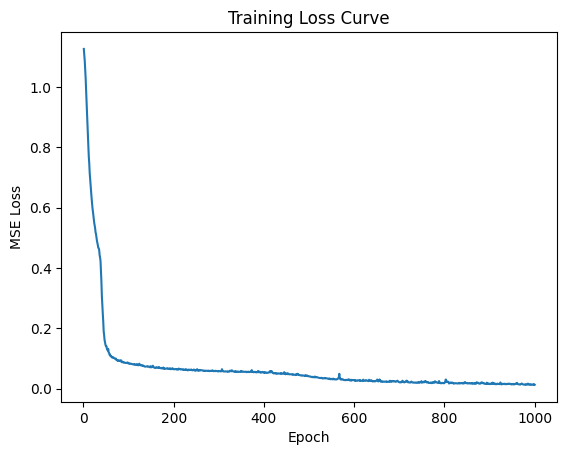

Fold 10 Validation MSE: 0.1487

=== CV Results: Mean MSE = 0.5491 ± 0.5783 ===
Fold 1 Validation MSE = 0.9150
Fold 2 Validation MSE = 0.1166
Fold 3 Validation MSE = 0.0935
Fold 4 Validation MSE = 0.5077
Fold 5 Validation MSE = 0.2026
Fold 6 Validation MSE = 0.7284
Fold 7 Validation MSE = 2.0886
Fold 8 Validation MSE = 0.4999
Fold 9 Validation MSE = 0.1895
Fold 10 Validation MSE = 0.1487


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [53]:
import uuid
import torch

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [3, 3],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      1000,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 10
)

# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''


=== Fold 1/10 ===
Epoch   1/500  MSE=1.1562
Epoch  10/500  MSE=0.9299
Epoch  20/500  MSE=0.4113
Epoch  30/500  MSE=0.2823
Epoch  40/500  MSE=0.2394
Epoch  50/500  MSE=0.2191
Epoch  60/500  MSE=0.2056
Epoch  70/500  MSE=0.1960
Epoch  80/500  MSE=0.1887
Epoch  90/500  MSE=0.1823
Epoch 100/500  MSE=0.1773
Epoch 110/500  MSE=0.1736
Epoch 120/500  MSE=0.1706
Epoch 130/500  MSE=0.1681
Epoch 140/500  MSE=0.1508
Epoch 150/500  MSE=0.1342
Epoch 160/500  MSE=0.1254
Epoch 170/500  MSE=0.1195
Epoch 180/500  MSE=0.1114
Epoch 190/500  MSE=0.1041
Epoch 200/500  MSE=0.1010
Epoch 210/500  MSE=0.0990
Epoch 220/500  MSE=0.0943
Epoch 230/500  MSE=0.0897
Epoch 240/500  MSE=0.0899
Epoch 250/500  MSE=0.0844
Epoch 260/500  MSE=0.0818
Epoch 270/500  MSE=0.0807
Epoch 280/500  MSE=0.0837
Epoch 290/500  MSE=0.0863
Epoch 300/500  MSE=0.0768
Epoch 310/500  MSE=0.0740
Epoch 320/500  MSE=0.0770
Epoch 330/500  MSE=0.0720
Epoch 340/500  MSE=0.0733
Epoch 350/500  MSE=0.0678
Epoch 360/500  MSE=0.0656
Epoch 370/500  MSE=

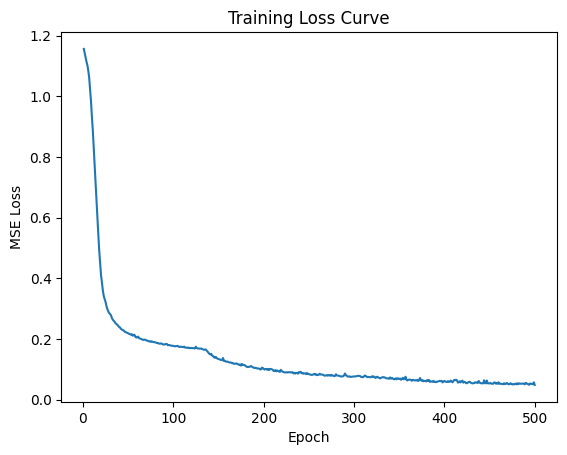

Fold 1 Validation MSE: 0.7479

=== Fold 2/10 ===
Epoch   1/500  MSE=1.6725
Epoch  10/500  MSE=0.9649
Epoch  20/500  MSE=0.7616
Epoch  30/500  MSE=0.6344
Epoch  40/500  MSE=0.5498
Epoch  50/500  MSE=0.4720
Epoch  60/500  MSE=0.4176
Epoch  70/500  MSE=0.3699
Epoch  80/500  MSE=0.3349
Epoch  90/500  MSE=0.2973
Epoch 100/500  MSE=0.2664
Epoch 110/500  MSE=0.2438
Epoch 120/500  MSE=0.2253
Epoch 130/500  MSE=0.2077
Epoch 140/500  MSE=0.2033
Epoch 150/500  MSE=0.1768
Epoch 160/500  MSE=0.1653
Epoch 170/500  MSE=0.1516
Epoch 180/500  MSE=0.1414
Epoch 190/500  MSE=0.1273
Epoch 200/500  MSE=0.1159
Epoch 210/500  MSE=0.1081
Epoch 220/500  MSE=0.0998
Epoch 230/500  MSE=0.0940
Epoch 240/500  MSE=0.0875
Epoch 250/500  MSE=0.0834
Epoch 260/500  MSE=0.0780
Epoch 270/500  MSE=0.0746
Epoch 280/500  MSE=0.0736
Epoch 290/500  MSE=0.0683
Epoch 300/500  MSE=0.0852
Epoch 310/500  MSE=0.0621
Epoch 320/500  MSE=0.0590
Epoch 330/500  MSE=0.0609
Epoch 340/500  MSE=0.0552
Epoch 350/500  MSE=0.0565
Epoch 360/500  

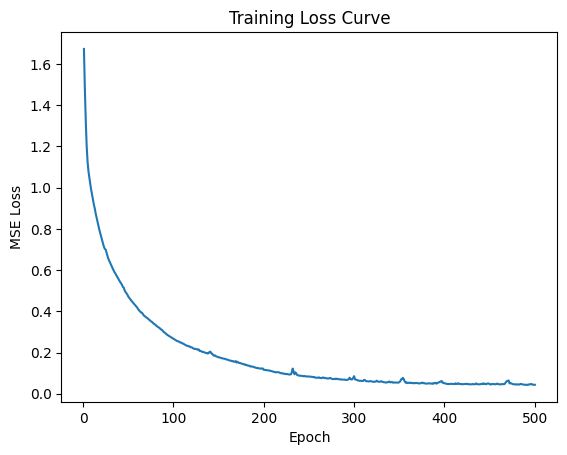

Fold 2 Validation MSE: 0.3427

=== Fold 3/10 ===
Epoch   1/500  MSE=1.4234
Epoch  10/500  MSE=0.6997
Epoch  20/500  MSE=0.2329
Epoch  30/500  MSE=0.1438
Epoch  40/500  MSE=0.1156
Epoch  50/500  MSE=0.1051
Epoch  60/500  MSE=0.0921
Epoch  70/500  MSE=0.0824
Epoch  80/500  MSE=0.0742
Epoch  90/500  MSE=0.0717
Epoch 100/500  MSE=0.0665
Epoch 110/500  MSE=0.0658
Epoch 120/500  MSE=0.0640
Epoch 130/500  MSE=0.0637
Epoch 140/500  MSE=0.0583
Epoch 150/500  MSE=0.0578
Epoch 160/500  MSE=0.0563
Epoch 170/500  MSE=0.0530
Epoch 180/500  MSE=0.0585
Epoch 190/500  MSE=0.0516
Epoch 200/500  MSE=0.0484
Epoch 210/500  MSE=0.0461
Epoch 220/500  MSE=0.0481
Epoch 230/500  MSE=0.0479
Epoch 240/500  MSE=0.0473
Epoch 250/500  MSE=0.0457
Epoch 260/500  MSE=0.0489
Epoch 270/500  MSE=0.0427
Epoch 280/500  MSE=0.0462
Epoch 290/500  MSE=0.0423
Epoch 300/500  MSE=0.0460
Epoch 310/500  MSE=0.0444
Epoch 320/500  MSE=0.0381
Epoch 330/500  MSE=0.0401
Epoch 340/500  MSE=0.0397
Epoch 350/500  MSE=0.0441
Epoch 360/500  

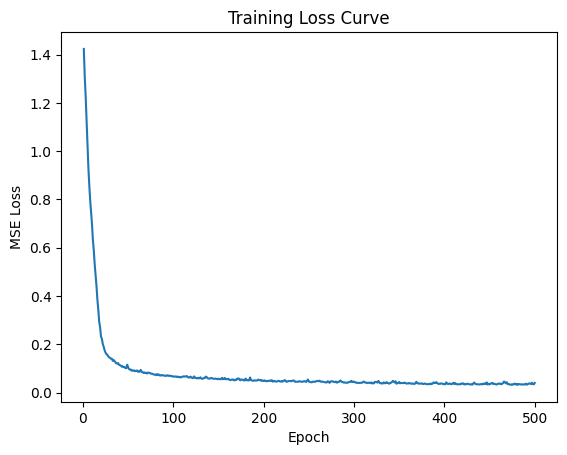

Fold 3 Validation MSE: 0.3584

=== Fold 4/10 ===
Epoch   1/500  MSE=1.1554
Epoch  10/500  MSE=0.8389
Epoch  20/500  MSE=0.6208
Epoch  30/500  MSE=0.5186
Epoch  40/500  MSE=0.4322
Epoch  50/500  MSE=0.3594
Epoch  60/500  MSE=0.3063
Epoch  70/500  MSE=0.2682
Epoch  80/500  MSE=0.2427
Epoch  90/500  MSE=0.2161
Epoch 100/500  MSE=0.2007
Epoch 110/500  MSE=0.1874
Epoch 120/500  MSE=0.1724
Epoch 130/500  MSE=0.1583
Epoch 140/500  MSE=0.1494
Epoch 150/500  MSE=0.1363
Epoch 160/500  MSE=0.1271
Epoch 170/500  MSE=0.1197
Epoch 180/500  MSE=0.1119
Epoch 190/500  MSE=0.1067
Epoch 200/500  MSE=0.1065
Epoch 210/500  MSE=0.1023
Epoch 220/500  MSE=0.0978
Epoch 230/500  MSE=0.1047
Epoch 240/500  MSE=0.0883
Epoch 250/500  MSE=0.0834
Epoch 260/500  MSE=0.0845
Epoch 270/500  MSE=0.0709
Epoch 280/500  MSE=0.0704
Epoch 290/500  MSE=0.0656
Epoch 300/500  MSE=0.0601
Epoch 310/500  MSE=0.0582
Epoch 320/500  MSE=0.0575
Epoch 330/500  MSE=0.0541
Epoch 340/500  MSE=0.0512
Epoch 350/500  MSE=0.0495
Epoch 360/500  

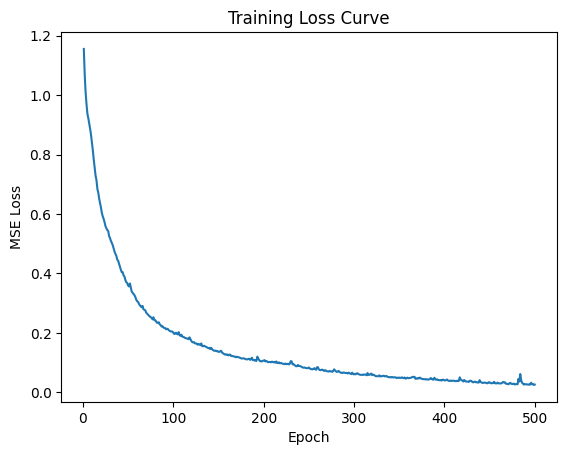

Fold 4 Validation MSE: 0.3512

=== Fold 5/10 ===
Epoch   1/500  MSE=1.3676
Epoch  10/500  MSE=1.0445
Epoch  20/500  MSE=0.9244
Epoch  30/500  MSE=0.7822
Epoch  40/500  MSE=0.6385
Epoch  50/500  MSE=0.5274
Epoch  60/500  MSE=0.4467
Epoch  70/500  MSE=0.3918
Epoch  80/500  MSE=0.3421
Epoch  90/500  MSE=0.3090
Epoch 100/500  MSE=0.2790
Epoch 110/500  MSE=0.2540
Epoch 120/500  MSE=0.2322
Epoch 130/500  MSE=0.2190
Epoch 140/500  MSE=0.1871
Epoch 150/500  MSE=0.1657
Epoch 160/500  MSE=0.1513
Epoch 170/500  MSE=0.1382
Epoch 180/500  MSE=0.1290
Epoch 190/500  MSE=0.1261
Epoch 200/500  MSE=0.1134
Epoch 210/500  MSE=0.1069
Epoch 220/500  MSE=0.1016
Epoch 230/500  MSE=0.0990
Epoch 240/500  MSE=0.0950
Epoch 250/500  MSE=0.0900
Epoch 260/500  MSE=0.0906
Epoch 270/500  MSE=0.0886
Epoch 280/500  MSE=0.0859
Epoch 290/500  MSE=0.0853
Epoch 300/500  MSE=0.0802
Epoch 310/500  MSE=0.0803
Epoch 320/500  MSE=0.0807
Epoch 330/500  MSE=0.0794
Epoch 340/500  MSE=0.0812
Epoch 350/500  MSE=0.0821
Epoch 360/500  

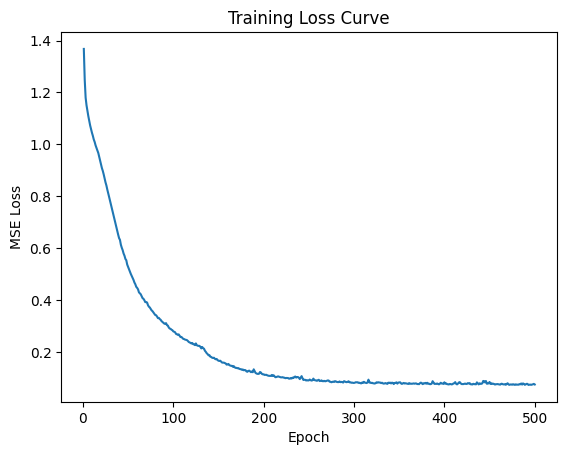

Fold 5 Validation MSE: 0.2469

=== Fold 6/10 ===
Epoch   1/500  MSE=1.1041
Epoch  10/500  MSE=0.7834
Epoch  20/500  MSE=0.4506
Epoch  30/500  MSE=0.2823
Epoch  40/500  MSE=0.1932
Epoch  50/500  MSE=0.1329
Epoch  60/500  MSE=0.1026
Epoch  70/500  MSE=0.0811
Epoch  80/500  MSE=0.0654
Epoch  90/500  MSE=0.0575
Epoch 100/500  MSE=0.0525
Epoch 110/500  MSE=0.0464
Epoch 120/500  MSE=0.0405
Epoch 130/500  MSE=0.0399
Epoch 140/500  MSE=0.0400
Epoch 150/500  MSE=0.0359
Epoch 160/500  MSE=0.0357
Epoch 170/500  MSE=0.0399
Epoch 180/500  MSE=0.0336
Epoch 190/500  MSE=0.0350
Epoch 200/500  MSE=0.0340
Epoch 210/500  MSE=0.0328
Epoch 220/500  MSE=0.0324
Epoch 230/500  MSE=0.0319
Epoch 240/500  MSE=0.0343
Epoch 250/500  MSE=0.0335
Epoch 260/500  MSE=0.0310
Epoch 270/500  MSE=0.0321
Epoch 280/500  MSE=0.0338
Epoch 290/500  MSE=0.0315
Epoch 300/500  MSE=0.0306
Epoch 310/500  MSE=0.0302
Epoch 320/500  MSE=0.0280
Epoch 330/500  MSE=0.0292
Epoch 340/500  MSE=0.0286
Epoch 350/500  MSE=0.0279
Epoch 360/500  

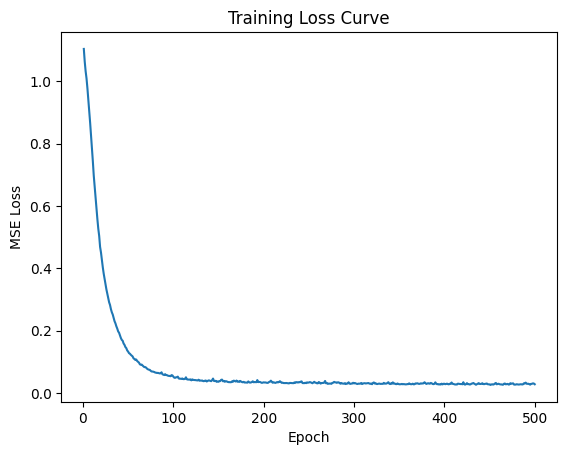

Fold 6 Validation MSE: 0.3802

=== Fold 7/10 ===
Epoch   1/500  MSE=0.9912
Epoch  10/500  MSE=0.8507
Epoch  20/500  MSE=0.6536
Epoch  30/500  MSE=0.5237
Epoch  40/500  MSE=0.4378
Epoch  50/500  MSE=0.3777
Epoch  60/500  MSE=0.3317
Epoch  70/500  MSE=0.2928
Epoch  80/500  MSE=0.2617
Epoch  90/500  MSE=0.2345
Epoch 100/500  MSE=0.2047
Epoch 110/500  MSE=0.1845
Epoch 120/500  MSE=0.1644
Epoch 130/500  MSE=0.1487
Epoch 140/500  MSE=0.1319
Epoch 150/500  MSE=0.1195
Epoch 160/500  MSE=0.1061
Epoch 170/500  MSE=0.0948
Epoch 180/500  MSE=0.0855
Epoch 190/500  MSE=0.0801
Epoch 200/500  MSE=0.0727
Epoch 210/500  MSE=0.0675
Epoch 220/500  MSE=0.0643
Epoch 230/500  MSE=0.0595
Epoch 240/500  MSE=0.0587
Epoch 250/500  MSE=0.0541
Epoch 260/500  MSE=0.0494
Epoch 270/500  MSE=0.0475
Epoch 280/500  MSE=0.0416
Epoch 290/500  MSE=0.0410
Epoch 300/500  MSE=0.0377
Epoch 310/500  MSE=0.0376
Epoch 320/500  MSE=0.0365
Epoch 330/500  MSE=0.0362
Epoch 340/500  MSE=0.0345
Epoch 350/500  MSE=0.0328
Epoch 360/500  

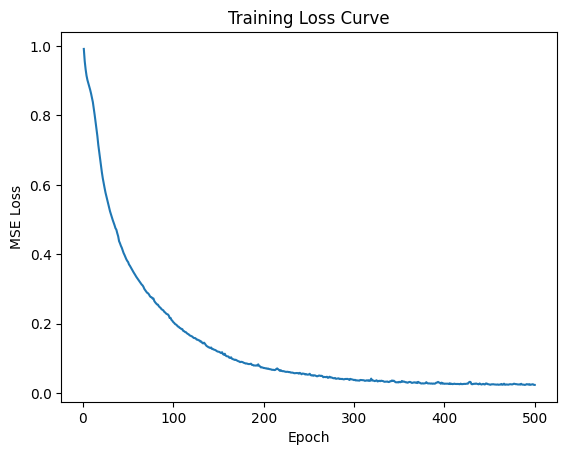

Fold 7 Validation MSE: 1.3148

=== Fold 8/10 ===
Epoch   1/500  MSE=1.0918
Epoch  10/500  MSE=0.6710
Epoch  20/500  MSE=0.2583
Epoch  30/500  MSE=0.2018
Epoch  40/500  MSE=0.1663
Epoch  50/500  MSE=0.1246
Epoch  60/500  MSE=0.1031
Epoch  70/500  MSE=0.0846
Epoch  80/500  MSE=0.0730
Epoch  90/500  MSE=0.0697
Epoch 100/500  MSE=0.0628
Epoch 110/500  MSE=0.0627
Epoch 120/500  MSE=0.0578
Epoch 130/500  MSE=0.0559
Epoch 140/500  MSE=0.0558
Epoch 150/500  MSE=0.0530
Epoch 160/500  MSE=0.0513
Epoch 170/500  MSE=0.0526
Epoch 180/500  MSE=0.0523
Epoch 190/500  MSE=0.0485
Epoch 200/500  MSE=0.0469
Epoch 210/500  MSE=0.0434
Epoch 220/500  MSE=0.0400
Epoch 230/500  MSE=0.0386
Epoch 240/500  MSE=0.0385
Epoch 250/500  MSE=0.0398
Epoch 260/500  MSE=0.0358
Epoch 270/500  MSE=0.0351
Epoch 280/500  MSE=0.0367
Epoch 290/500  MSE=0.0353
Epoch 300/500  MSE=0.0392
Epoch 310/500  MSE=0.0379
Epoch 320/500  MSE=0.0354
Epoch 330/500  MSE=0.0350
Epoch 340/500  MSE=0.0362
Epoch 350/500  MSE=0.0354
Epoch 360/500  

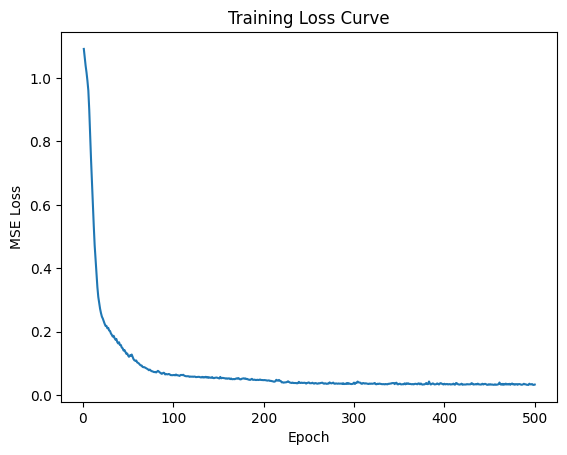

Fold 8 Validation MSE: 0.5416

=== Fold 9/10 ===
Epoch   1/500  MSE=1.0503
Epoch  10/500  MSE=0.7467
Epoch  20/500  MSE=0.2486
Epoch  30/500  MSE=0.1603
Epoch  40/500  MSE=0.1240
Epoch  50/500  MSE=0.1007
Epoch  60/500  MSE=0.0896
Epoch  70/500  MSE=0.0812
Epoch  80/500  MSE=0.0734
Epoch  90/500  MSE=0.0701
Epoch 100/500  MSE=0.0648
Epoch 110/500  MSE=0.0579
Epoch 120/500  MSE=0.0518
Epoch 130/500  MSE=0.0495
Epoch 140/500  MSE=0.0461
Epoch 150/500  MSE=0.0443
Epoch 160/500  MSE=0.0419
Epoch 170/500  MSE=0.0419
Epoch 180/500  MSE=0.0451
Epoch 190/500  MSE=0.0366
Epoch 200/500  MSE=0.0360
Epoch 210/500  MSE=0.0347
Epoch 220/500  MSE=0.0359
Epoch 230/500  MSE=0.0330
Epoch 240/500  MSE=0.0338
Epoch 250/500  MSE=0.0314
Epoch 260/500  MSE=0.0290
Epoch 270/500  MSE=0.0292
Epoch 280/500  MSE=0.0285
Epoch 290/500  MSE=0.0298
Epoch 300/500  MSE=0.0308
Epoch 310/500  MSE=0.0288
Epoch 320/500  MSE=0.0268
Epoch 330/500  MSE=0.0266
Epoch 340/500  MSE=0.0280
Epoch 350/500  MSE=0.0266
Epoch 360/500  

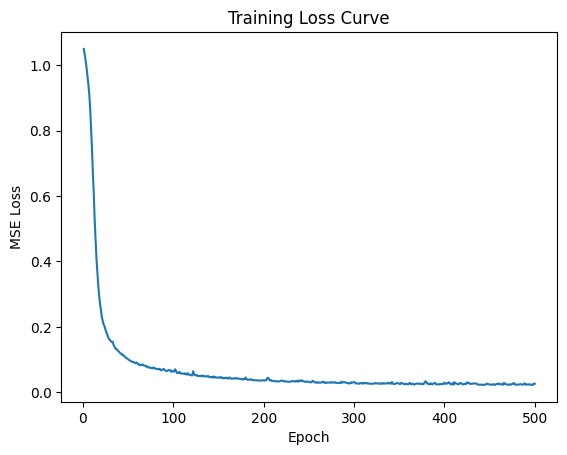

Fold 9 Validation MSE: 0.2888

=== Fold 10/10 ===
Epoch   1/500  MSE=1.0518
Epoch  10/500  MSE=0.5501
Epoch  20/500  MSE=0.1768
Epoch  30/500  MSE=0.1386
Epoch  40/500  MSE=0.1093
Epoch  50/500  MSE=0.0908
Epoch  60/500  MSE=0.0826
Epoch  70/500  MSE=0.0716
Epoch  80/500  MSE=0.0648
Epoch  90/500  MSE=0.0610
Epoch 100/500  MSE=0.0603
Epoch 110/500  MSE=0.0542
Epoch 120/500  MSE=0.0506
Epoch 130/500  MSE=0.0478
Epoch 140/500  MSE=0.0467
Epoch 150/500  MSE=0.0423
Epoch 160/500  MSE=0.0428
Epoch 170/500  MSE=0.0392
Epoch 180/500  MSE=0.0373
Epoch 190/500  MSE=0.0375
Epoch 200/500  MSE=0.0366
Epoch 210/500  MSE=0.0349
Epoch 220/500  MSE=0.0334
Epoch 230/500  MSE=0.0328
Epoch 240/500  MSE=0.0335
Epoch 250/500  MSE=0.0306
Epoch 260/500  MSE=0.0289
Epoch 270/500  MSE=0.0295
Epoch 280/500  MSE=0.0282
Epoch 290/500  MSE=0.0307
Epoch 300/500  MSE=0.0274
Epoch 310/500  MSE=0.0294
Epoch 320/500  MSE=0.0278
Epoch 330/500  MSE=0.0257
Epoch 340/500  MSE=0.0296
Epoch 350/500  MSE=0.0252
Epoch 360/500 

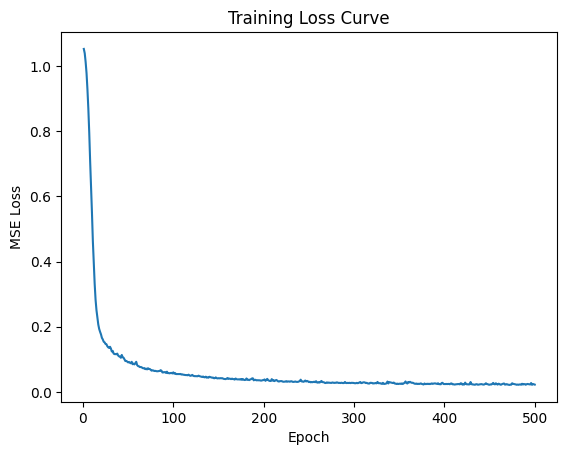

Fold 10 Validation MSE: 0.2124

=== CV Results: Mean MSE = 0.4785 ± 0.3155 ===
Fold 1 Validation MSE = 0.7479
Fold 2 Validation MSE = 0.3427
Fold 3 Validation MSE = 0.3584
Fold 4 Validation MSE = 0.3512
Fold 5 Validation MSE = 0.2469
Fold 6 Validation MSE = 0.3802
Fold 7 Validation MSE = 1.3148
Fold 8 Validation MSE = 0.5416
Fold 9 Validation MSE = 0.2888
Fold 10 Validation MSE = 0.2124


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [54]:
import uuid
import torch

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [3, 3],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      500,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 10
)

# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''


=== Fold 1/10 ===
Epoch   1/250  MSE=1.3057
Epoch  10/250  MSE=0.8481
Epoch  20/250  MSE=0.5397
Epoch  30/250  MSE=0.3259
Epoch  40/250  MSE=0.2290
Epoch  50/250  MSE=0.1630
Epoch  60/250  MSE=0.1190
Epoch  70/250  MSE=0.0877
Epoch  80/250  MSE=0.0701
Epoch  90/250  MSE=0.0597
Epoch 100/250  MSE=0.0474
Epoch 110/250  MSE=0.0442
Epoch 120/250  MSE=0.0390
Epoch 130/250  MSE=0.0371
Epoch 140/250  MSE=0.0357
Epoch 150/250  MSE=0.0352
Epoch 160/250  MSE=0.0375
Epoch 170/250  MSE=0.0343
Epoch 180/250  MSE=0.0325
Epoch 190/250  MSE=0.0351
Epoch 200/250  MSE=0.0302
Epoch 210/250  MSE=0.0315
Epoch 220/250  MSE=0.0416
Epoch 230/250  MSE=0.0310
Epoch 240/250  MSE=0.0360
Epoch 250/250  MSE=0.0296


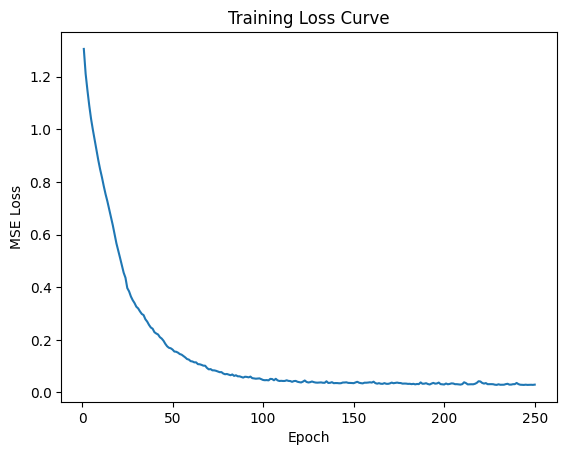

Fold 1 Validation MSE: 0.4385

=== Fold 2/10 ===
Epoch   1/250  MSE=0.9873
Epoch  10/250  MSE=0.8703
Epoch  20/250  MSE=0.7297
Epoch  30/250  MSE=0.6332
Epoch  40/250  MSE=0.5408
Epoch  50/250  MSE=0.3846
Epoch  60/250  MSE=0.3225
Epoch  70/250  MSE=0.2747
Epoch  80/250  MSE=0.2401
Epoch  90/250  MSE=0.2140
Epoch 100/250  MSE=0.1948
Epoch 110/250  MSE=0.1759
Epoch 120/250  MSE=0.1624
Epoch 130/250  MSE=0.1483
Epoch 140/250  MSE=0.1396
Epoch 150/250  MSE=0.1296
Epoch 160/250  MSE=0.1234
Epoch 170/250  MSE=0.1185
Epoch 180/250  MSE=0.1123
Epoch 190/250  MSE=0.1071
Epoch 200/250  MSE=0.1033
Epoch 210/250  MSE=0.0978
Epoch 220/250  MSE=0.0918
Epoch 230/250  MSE=0.0896
Epoch 240/250  MSE=0.0857
Epoch 250/250  MSE=0.0891


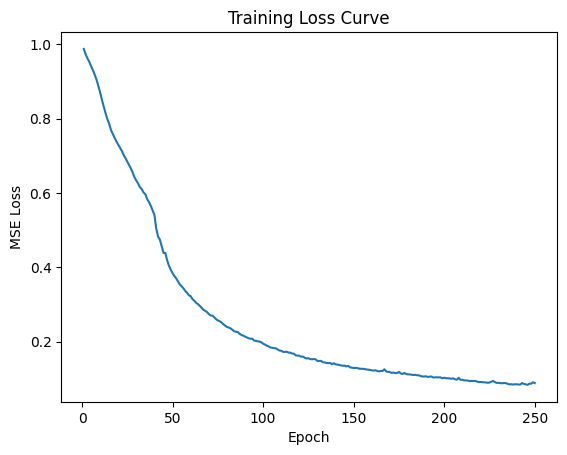

Fold 2 Validation MSE: 0.4228

=== Fold 3/10 ===
Epoch   1/250  MSE=1.0277
Epoch  10/250  MSE=0.7344
Epoch  20/250  MSE=0.2522
Epoch  30/250  MSE=0.1534
Epoch  40/250  MSE=0.1215
Epoch  50/250  MSE=0.1050
Epoch  60/250  MSE=0.0912
Epoch  70/250  MSE=0.0896
Epoch  80/250  MSE=0.0785
Epoch  90/250  MSE=0.0728
Epoch 100/250  MSE=0.0694
Epoch 110/250  MSE=0.0687
Epoch 120/250  MSE=0.0646
Epoch 130/250  MSE=0.0643
Epoch 140/250  MSE=0.0630
Epoch 150/250  MSE=0.0615
Epoch 160/250  MSE=0.0769
Epoch 170/250  MSE=0.0569
Epoch 180/250  MSE=0.0549
Epoch 190/250  MSE=0.0575
Epoch 200/250  MSE=0.0507
Epoch 210/250  MSE=0.0492
Epoch 220/250  MSE=0.0495
Epoch 230/250  MSE=0.0466
Epoch 240/250  MSE=0.0437
Epoch 250/250  MSE=0.0428


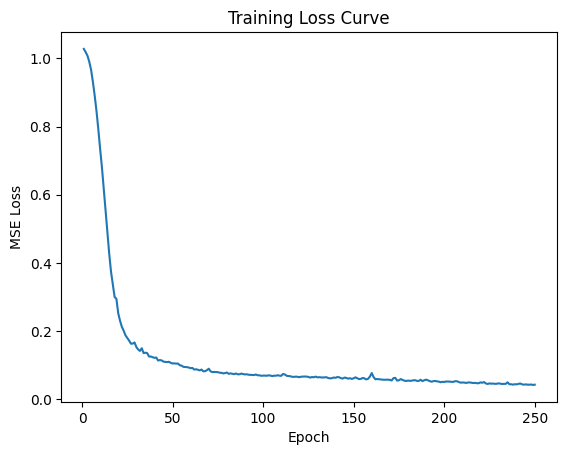

Fold 3 Validation MSE: 0.2202

=== Fold 4/10 ===
Epoch   1/250  MSE=0.9780
Epoch  10/250  MSE=0.9223
Epoch  20/250  MSE=0.4843
Epoch  30/250  MSE=0.3107
Epoch  40/250  MSE=0.2721
Epoch  50/250  MSE=0.2517
Epoch  60/250  MSE=0.2334
Epoch  70/250  MSE=0.2214
Epoch  80/250  MSE=0.2139
Epoch  90/250  MSE=0.2095
Epoch 100/250  MSE=0.2030
Epoch 110/250  MSE=0.1931
Epoch 120/250  MSE=0.1738
Epoch 130/250  MSE=0.1626
Epoch 140/250  MSE=0.1425
Epoch 150/250  MSE=0.1258
Epoch 160/250  MSE=0.1210
Epoch 170/250  MSE=0.1138
Epoch 180/250  MSE=0.1091
Epoch 190/250  MSE=0.1096
Epoch 200/250  MSE=0.1079
Epoch 210/250  MSE=0.1031
Epoch 220/250  MSE=0.1010
Epoch 230/250  MSE=0.1000
Epoch 240/250  MSE=0.0950
Epoch 250/250  MSE=0.0946


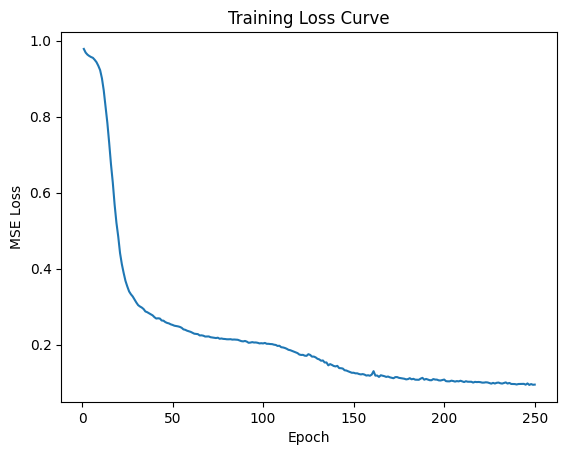

Fold 4 Validation MSE: 0.1364

=== Fold 5/10 ===
Epoch   1/250  MSE=0.9874
Epoch  10/250  MSE=0.8383
Epoch  20/250  MSE=0.5563
Epoch  30/250  MSE=0.4240
Epoch  40/250  MSE=0.3508
Epoch  50/250  MSE=0.3042
Epoch  60/250  MSE=0.2641
Epoch  70/250  MSE=0.1156
Epoch  80/250  MSE=0.0864
Epoch  90/250  MSE=0.0767
Epoch 100/250  MSE=0.0717
Epoch 110/250  MSE=0.0667
Epoch 120/250  MSE=0.0635
Epoch 130/250  MSE=0.0651
Epoch 140/250  MSE=0.0610
Epoch 150/250  MSE=0.0626
Epoch 160/250  MSE=0.0634
Epoch 170/250  MSE=0.0581
Epoch 180/250  MSE=0.0579
Epoch 190/250  MSE=0.0611
Epoch 200/250  MSE=0.0597
Epoch 210/250  MSE=0.0613
Epoch 220/250  MSE=0.0568
Epoch 230/250  MSE=0.0568
Epoch 240/250  MSE=0.0561
Epoch 250/250  MSE=0.0599


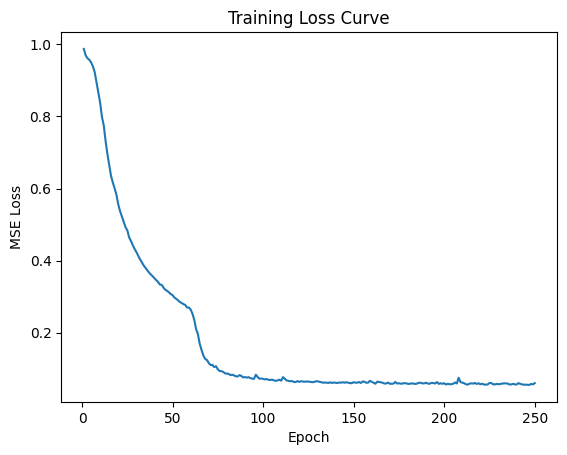

Fold 5 Validation MSE: 0.1181

=== Fold 6/10 ===
Epoch   1/250  MSE=1.2869
Epoch  10/250  MSE=0.7728
Epoch  20/250  MSE=0.3270
Epoch  30/250  MSE=0.2359
Epoch  40/250  MSE=0.2079
Epoch  50/250  MSE=0.1905
Epoch  60/250  MSE=0.1793
Epoch  70/250  MSE=0.1552
Epoch  80/250  MSE=0.1460
Epoch  90/250  MSE=0.1370
Epoch 100/250  MSE=0.1296
Epoch 110/250  MSE=0.1236
Epoch 120/250  MSE=0.1156
Epoch 130/250  MSE=0.1094
Epoch 140/250  MSE=0.1042
Epoch 150/250  MSE=0.1010
Epoch 160/250  MSE=0.0935
Epoch 170/250  MSE=0.0902
Epoch 180/250  MSE=0.0841
Epoch 190/250  MSE=0.0825
Epoch 200/250  MSE=0.0792
Epoch 210/250  MSE=0.0755
Epoch 220/250  MSE=0.0733
Epoch 230/250  MSE=0.0746
Epoch 240/250  MSE=0.0719
Epoch 250/250  MSE=0.0678


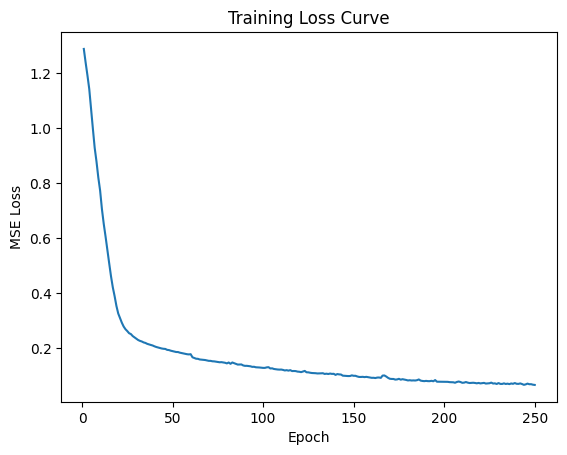

Fold 6 Validation MSE: 0.5378

=== Fold 7/10 ===
Epoch   1/250  MSE=1.1520
Epoch  10/250  MSE=0.8267
Epoch  20/250  MSE=0.4009
Epoch  30/250  MSE=0.2333
Epoch  40/250  MSE=0.1203
Epoch  50/250  MSE=0.0917
Epoch  60/250  MSE=0.0797
Epoch  70/250  MSE=0.0739
Epoch  80/250  MSE=0.0675
Epoch  90/250  MSE=0.0623
Epoch 100/250  MSE=0.0610
Epoch 110/250  MSE=0.0594
Epoch 120/250  MSE=0.0574
Epoch 130/250  MSE=0.0550
Epoch 140/250  MSE=0.0589
Epoch 150/250  MSE=0.0525
Epoch 160/250  MSE=0.0538
Epoch 170/250  MSE=0.0521
Epoch 180/250  MSE=0.0524
Epoch 190/250  MSE=0.0490
Epoch 200/250  MSE=0.0479
Epoch 210/250  MSE=0.0490
Epoch 220/250  MSE=0.0462
Epoch 230/250  MSE=0.0468
Epoch 240/250  MSE=0.0459
Epoch 250/250  MSE=0.0434


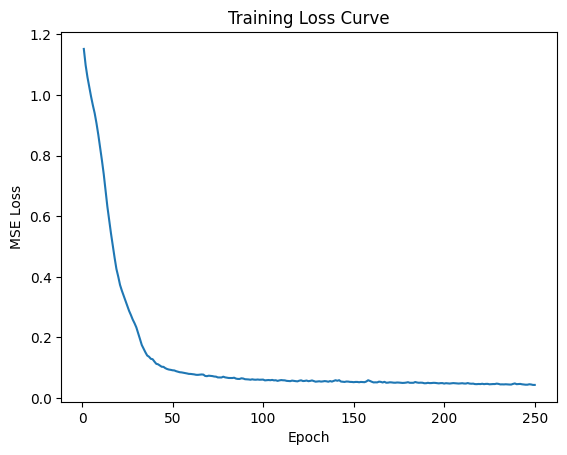

Fold 7 Validation MSE: 1.3828

=== Fold 8/10 ===
Epoch   1/250  MSE=0.9870
Epoch  10/250  MSE=0.7659
Epoch  20/250  MSE=0.2835
Epoch  30/250  MSE=0.1389
Epoch  40/250  MSE=0.1116
Epoch  50/250  MSE=0.0940
Epoch  60/250  MSE=0.0792
Epoch  70/250  MSE=0.0677
Epoch  80/250  MSE=0.0626
Epoch  90/250  MSE=0.0572
Epoch 100/250  MSE=0.0561
Epoch 110/250  MSE=0.0525
Epoch 120/250  MSE=0.0503
Epoch 130/250  MSE=0.0480
Epoch 140/250  MSE=0.0467
Epoch 150/250  MSE=0.0458
Epoch 160/250  MSE=0.0443
Epoch 170/250  MSE=0.0385
Epoch 180/250  MSE=0.0401
Epoch 190/250  MSE=0.0360
Epoch 200/250  MSE=0.0397
Epoch 210/250  MSE=0.0351
Epoch 220/250  MSE=0.0369
Epoch 230/250  MSE=0.0330
Epoch 240/250  MSE=0.0336
Epoch 250/250  MSE=0.0325


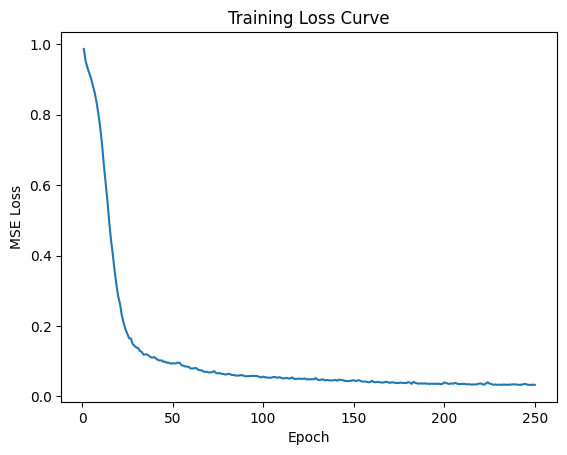

Fold 8 Validation MSE: 0.4179

=== Fold 9/10 ===
Epoch   1/250  MSE=1.0871
Epoch  10/250  MSE=0.7602
Epoch  20/250  MSE=0.4634
Epoch  30/250  MSE=0.3013
Epoch  40/250  MSE=0.2043
Epoch  50/250  MSE=0.1421
Epoch  60/250  MSE=0.1074
Epoch  70/250  MSE=0.0802
Epoch  80/250  MSE=0.0633
Epoch  90/250  MSE=0.0551
Epoch 100/250  MSE=0.0505
Epoch 110/250  MSE=0.0474
Epoch 120/250  MSE=0.0443
Epoch 130/250  MSE=0.0408
Epoch 140/250  MSE=0.0407
Epoch 150/250  MSE=0.0407
Epoch 160/250  MSE=0.0443
Epoch 170/250  MSE=0.0408
Epoch 180/250  MSE=0.0368
Epoch 190/250  MSE=0.0356
Epoch 200/250  MSE=0.0342
Epoch 210/250  MSE=0.0336
Epoch 220/250  MSE=0.0340
Epoch 230/250  MSE=0.0385
Epoch 240/250  MSE=0.0356
Epoch 250/250  MSE=0.0351


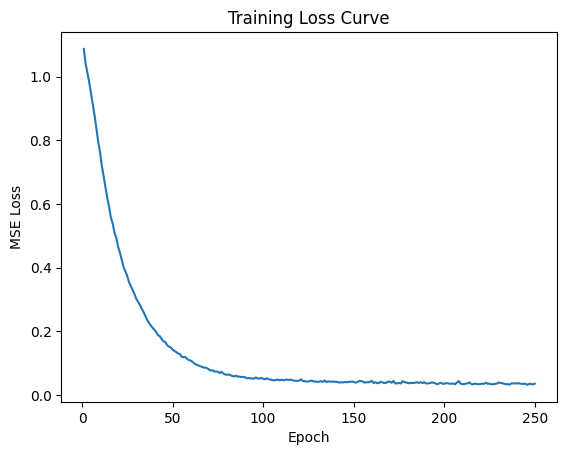

Fold 9 Validation MSE: 0.0949

=== Fold 10/10 ===
Epoch   1/250  MSE=1.0704
Epoch  10/250  MSE=0.8701
Epoch  20/250  MSE=0.5899
Epoch  30/250  MSE=0.4590
Epoch  40/250  MSE=0.3843
Epoch  50/250  MSE=0.3288
Epoch  60/250  MSE=0.2853
Epoch  70/250  MSE=0.2570
Epoch  80/250  MSE=0.2311
Epoch  90/250  MSE=0.2121
Epoch 100/250  MSE=0.1958
Epoch 110/250  MSE=0.1692
Epoch 120/250  MSE=0.1579
Epoch 130/250  MSE=0.1484
Epoch 140/250  MSE=0.1428
Epoch 150/250  MSE=0.1506
Epoch 160/250  MSE=0.1298
Epoch 170/250  MSE=0.1200
Epoch 180/250  MSE=0.1144
Epoch 190/250  MSE=0.1094
Epoch 200/250  MSE=0.0998
Epoch 210/250  MSE=0.0946
Epoch 220/250  MSE=0.0850
Epoch 230/250  MSE=0.0728
Epoch 240/250  MSE=0.0703
Epoch 250/250  MSE=0.0647


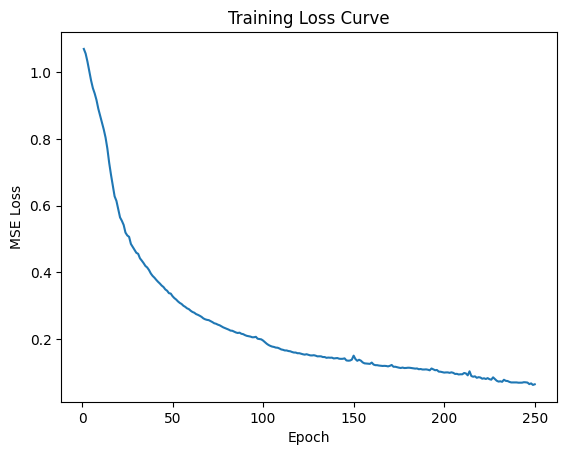

Fold 10 Validation MSE: 0.1984

=== CV Results: Mean MSE = 0.3968 ± 0.3609 ===
Fold 1 Validation MSE = 0.4385
Fold 2 Validation MSE = 0.4228
Fold 3 Validation MSE = 0.2202
Fold 4 Validation MSE = 0.1364
Fold 5 Validation MSE = 0.1181
Fold 6 Validation MSE = 0.5378
Fold 7 Validation MSE = 1.3828
Fold 8 Validation MSE = 0.4179
Fold 9 Validation MSE = 0.0949
Fold 10 Validation MSE = 0.1984


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [55]:
import uuid
import torch

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [3, 3],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 10
)

# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# singel run

Epoch   1/2000  MSE=1.6333
Epoch  10/2000  MSE=1.1304
Epoch  20/2000  MSE=0.8514
Epoch  30/2000  MSE=0.7019
Epoch  40/2000  MSE=0.6252
Epoch  50/2000  MSE=0.5636
Epoch  60/2000  MSE=0.5059
Epoch  70/2000  MSE=0.4324
Epoch  80/2000  MSE=0.3791
Epoch  90/2000  MSE=0.3405
Epoch 100/2000  MSE=0.3007
Epoch 110/2000  MSE=0.2711
Epoch 120/2000  MSE=0.2442
Epoch 130/2000  MSE=0.2253
Epoch 140/2000  MSE=0.2133
Epoch 150/2000  MSE=0.1890
Epoch 160/2000  MSE=0.1738
Epoch 170/2000  MSE=0.1674
Epoch 180/2000  MSE=0.1533
Epoch 190/2000  MSE=0.1430
Epoch 200/2000  MSE=0.1334
Epoch 210/2000  MSE=0.1384
Epoch 220/2000  MSE=0.1257
Epoch 230/2000  MSE=0.1222
Epoch 240/2000  MSE=0.1162
Epoch 250/2000  MSE=0.1058
Epoch 260/2000  MSE=0.1086
Epoch 270/2000  MSE=0.0972
Epoch 280/2000  MSE=0.0978
Epoch 290/2000  MSE=0.0907
Epoch 300/2000  MSE=0.0883
Epoch 310/2000  MSE=0.0888
Epoch 320/2000  MSE=0.0811
Epoch 330/2000  MSE=0.0756
Epoch 340/2000  MSE=0.0793
Epoch 350/2000  MSE=0.0707
Epoch 360/2000  MSE=0.0691
E

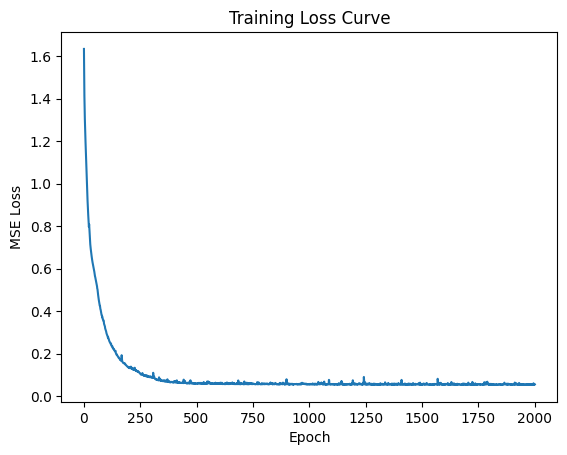

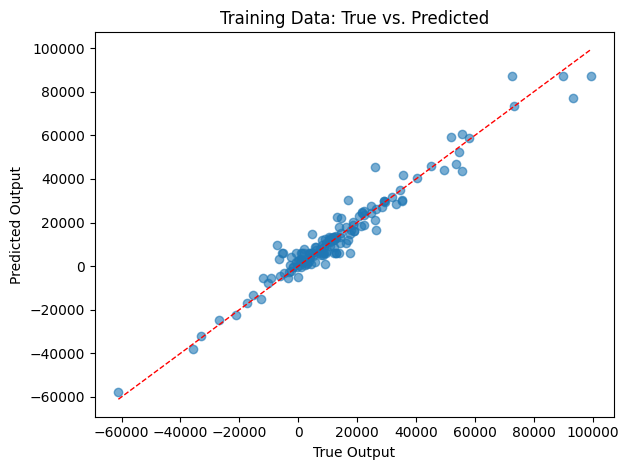

Saved model to:  trained_model_7102add2.pt
Saved params to: trained_model_7102add2_params.txt


In [49]:
import uuid
import torch

# 1) Generate a random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [2, 2],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      2000,
    'batch_size':  8
}

# 3) Train your model
model, losses = train_nn(
    X, y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size']
)

# 4) Plot true vs. predicted
plot_train_scatter(model, X, y, scaler_y=scaler_y, device='cpu')

# 5) Construct filenames with tag
model_fp  = f"trained_model_{tag}.pt"
params_fp = f"trained_model_{tag}_params.txt"

# 6) Save the model weights
torch.save(model.state_dict(), model_fp)

# 7) Save the hyper-parameters
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")

print(f"Saved model to:  {model_fp}")
print(f"Saved params to: {params_fp}")
